# Compound Events
- https://github.com/e-baumer/standard_precip

In [1]:
%%time
import os
import pandas as pd
import warnings
from plot import Plot
from process import Compound
warnings.filterwarnings('ignore')

event = ['CWHE','CDHE'][1]
months = [6, 7, 8]
center='LARC'


freq, scale, gamma_n = 'D', 30, [10, 20, 30][2]
# if scale < gamma_n:
#     raise ValueError('SPI time scale must be >= Number of data points used to fit gamma')

plotly = False

metrics = {
    '_duration_mean$':  f'Average {event} Event Duration',
    '_sequence_total$': f'Total {event} Event Sequences',
    '_event_max$':      f'Max Consecutive {event} Events',
    '_event_total$':    f'Total {event} Events',
    '_day_total$':      f'Total {event} Days'
}

def setup_thresholds(event):
    '''Set up thresholds for different severity levels of compound events.'''
    def f_to_c(f):
        return (f - 32) * 5/9
            
    if event == 'CDHE':
        spi_op, tm_op = '<', '>' # spi (standardized), tm (f->c)
        return[{'spi': (spi_op, -1), 'tasmax': (tm_op, f_to_c(90))},
               {'spi': (spi_op, -2), 'tasmax': (tm_op, f_to_c(90))}]
    elif event == 'CWHE':
        spi_op, tm_op = '>', '>' # spi (standardized), tm (f->c)
        return[{'spi': (spi_op, 1), 'tasmax': (tm_op, f_to_c(90))},
               {'spi': (spi_op, 2), 'tasmax': (tm_op, f_to_c(90))}]
    else:
        raise ValueError('Invalid event type')
        
thresholds = setup_thresholds(event)

result, compound, pr_spi, tm, pr, tm, spi= Compound(center, event, months, freq, scale, 
                                                    thresholds, gamma_n).main()

Processing ssp126 spi (1980-01-01 to 2100-12-31)...
--> filtered: 1981-01-01 to 2100-12-31
--> base: 1981 to 2020
Processing ssp245 spi (1980-01-01 to 2100-12-31)...
--> filtered: 1981-01-01 to 2100-12-31
--> base: 1981 to 2020
Processing ssp370 spi (1980-01-01 to 2100-12-31)...
--> filtered: 1981-01-01 to 2100-12-31
--> base: 1981 to 2020
CPU times: user 15.1 s, sys: 306 ms, total: 15.4 s
Wall time: 15.5 s


# Analysis
## Trends

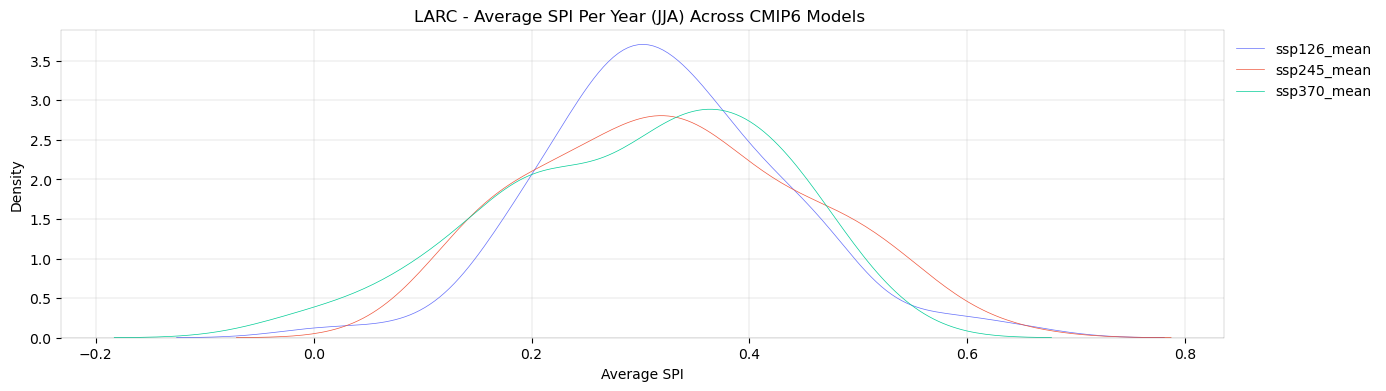

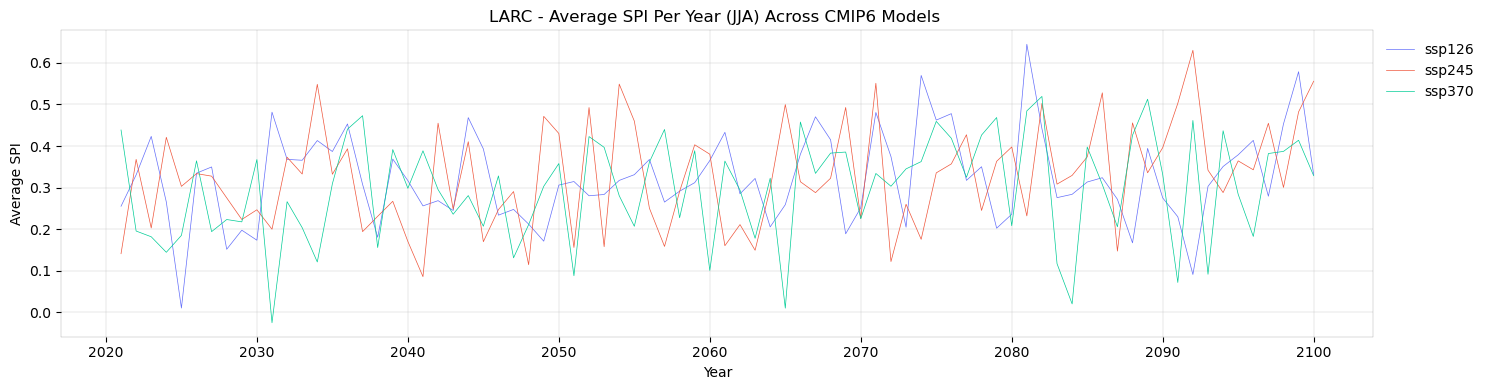

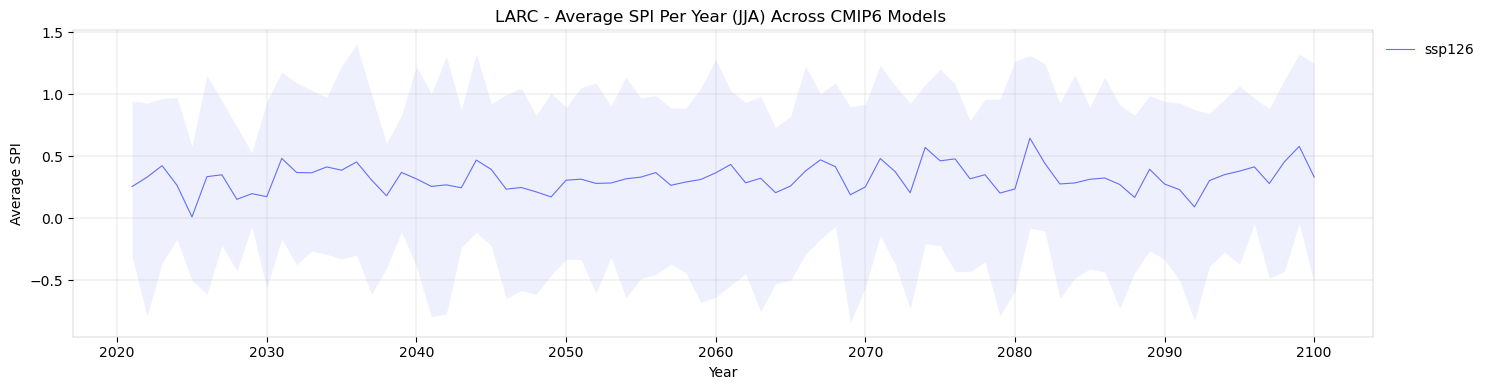

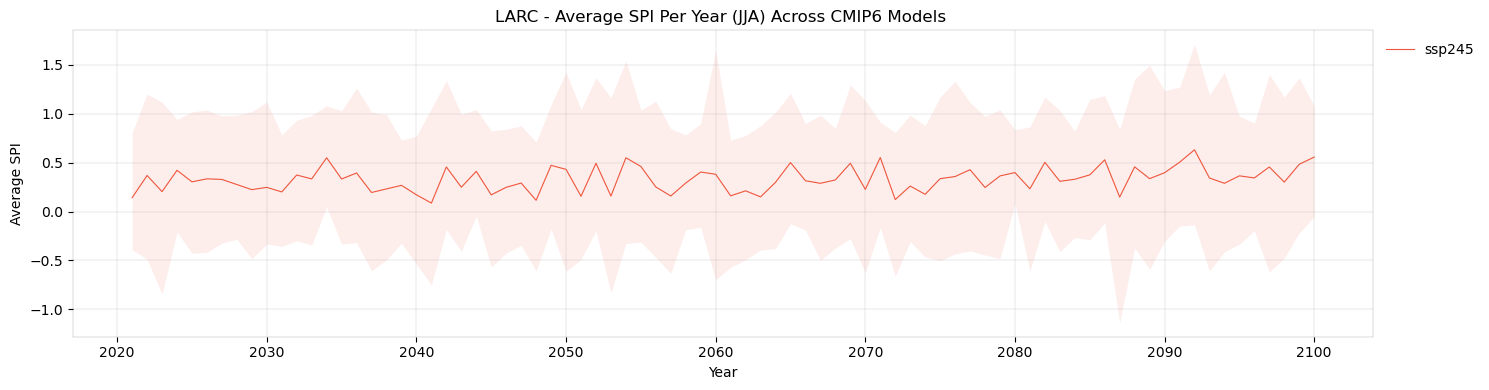

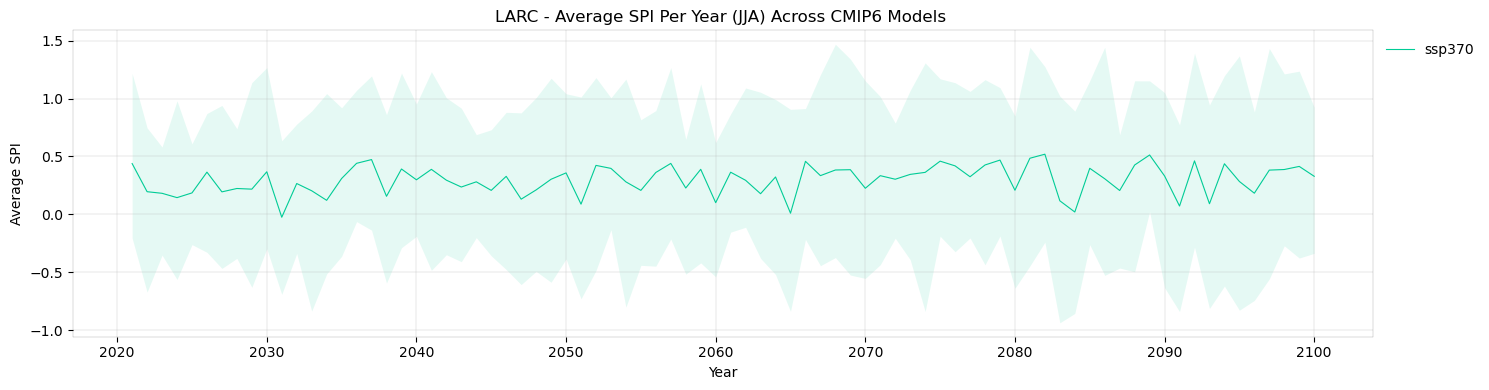

In [2]:
# SPI
p = Plot(center, months, f'Average SPI', '_spi$')
p.dist_sns(spi)
p.ts_plotly(spi) if plotly else p.ts_sns(spi)

In [3]:
# # Max Temperature
# p = Plot(center, months, f'Average Max Temperature', '_tasmax$')
# p.dist_sns(tm)
# p.ts_plotly(tm) if plotly else p.ts_sns(tm)

In [4]:
# # Precipitation
# p = Plot(center, months, f'Average Precipitation', '_pr$')
# p.dist_sns(pr)
# p.ts_plotly(pr) if plotly else p.ts_sns(pr)

## Compound

In [5]:
# display(result['spi<-1_tasmax>32.2'].filter(regex='ACCESS-CM2'))

In [6]:
# # Total Compound Days
# m = '_day_total$'
# Plot(center, months, metrics[m], m).all(result, plotly)

In [7]:
# # Total Compound Events
# m = '_event_total$'
# Plot(center, months, metrics[m], m).all(result, plotly)

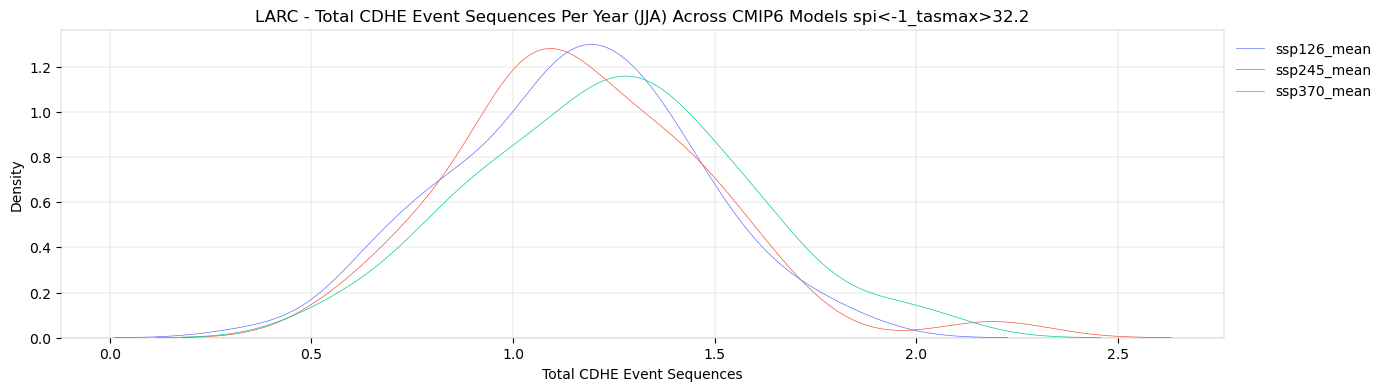

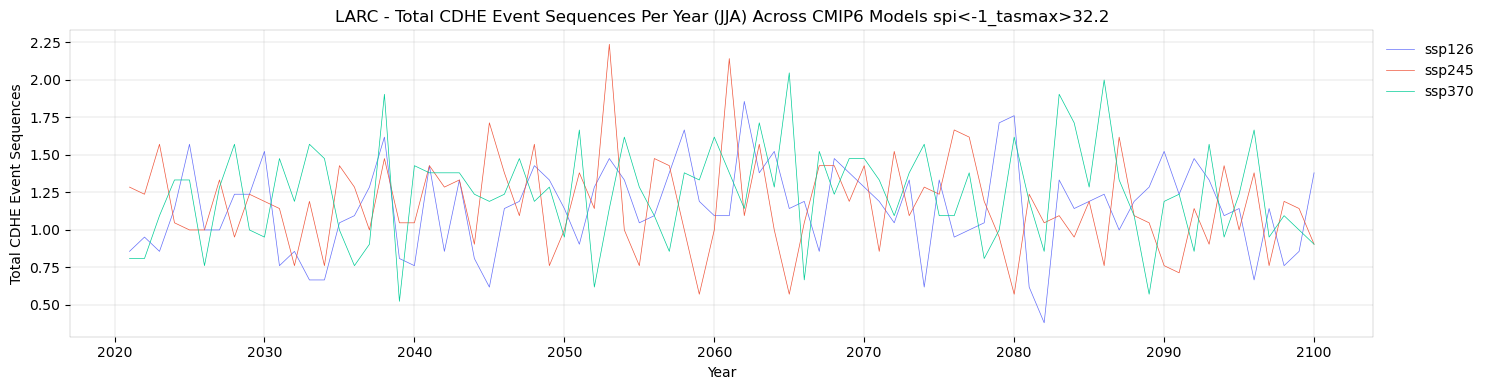

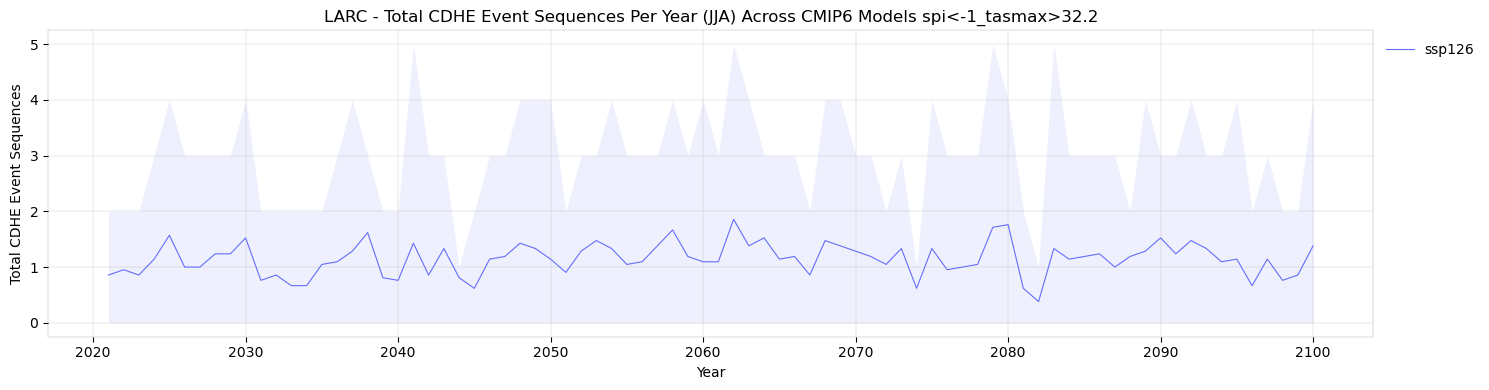

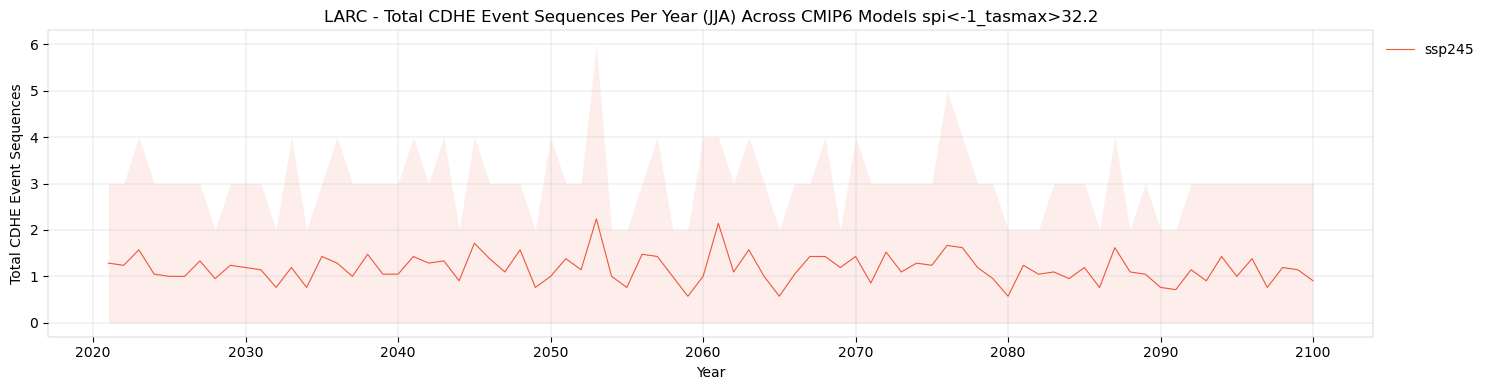

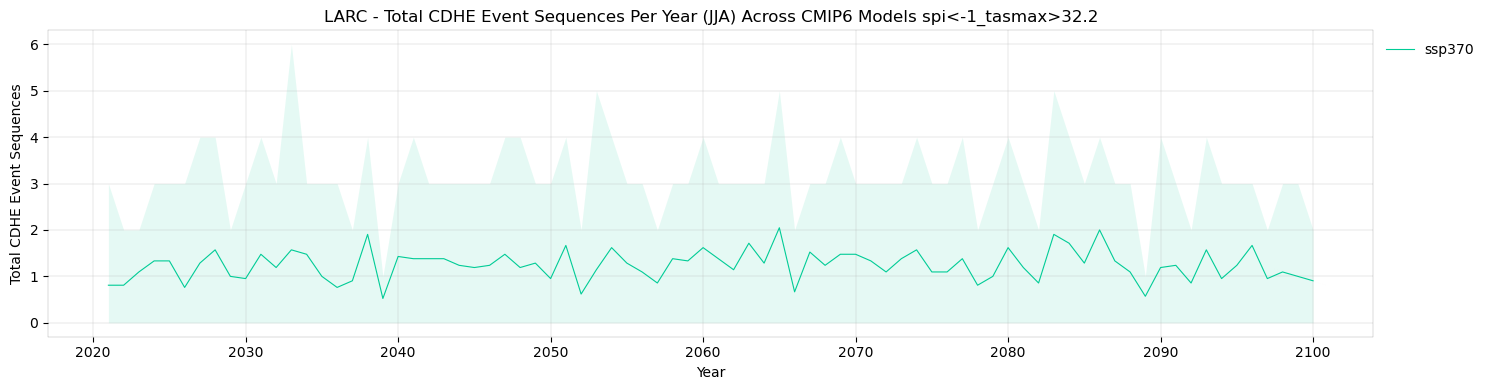

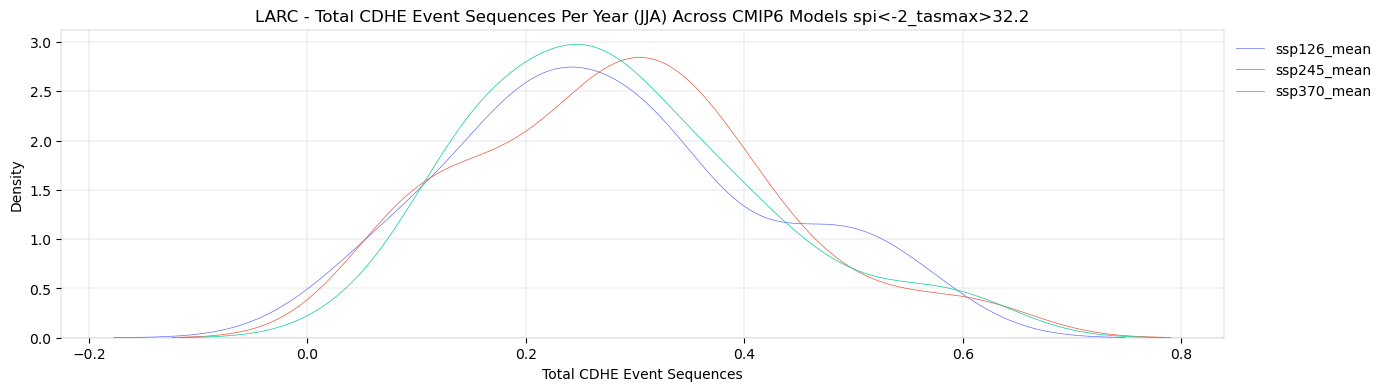

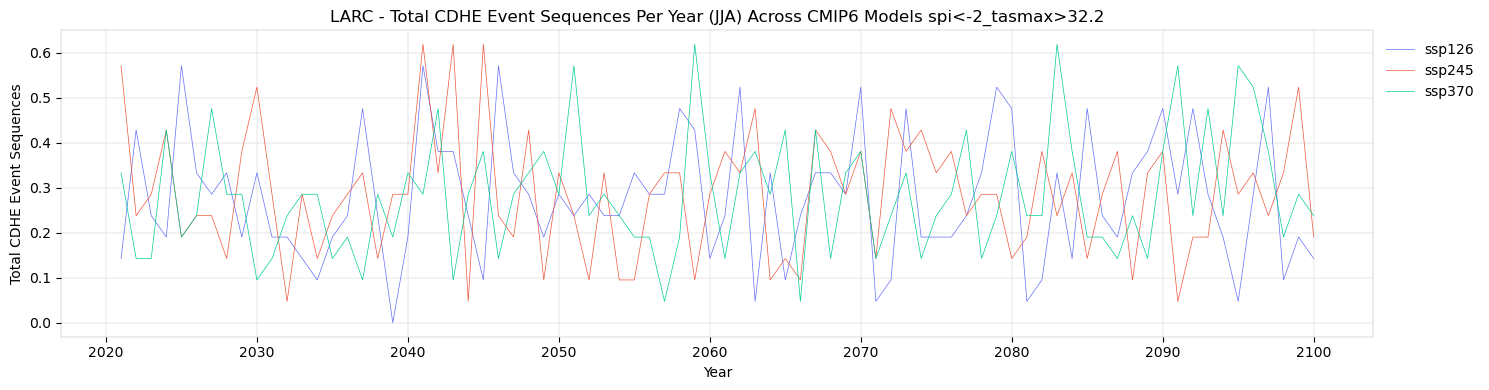

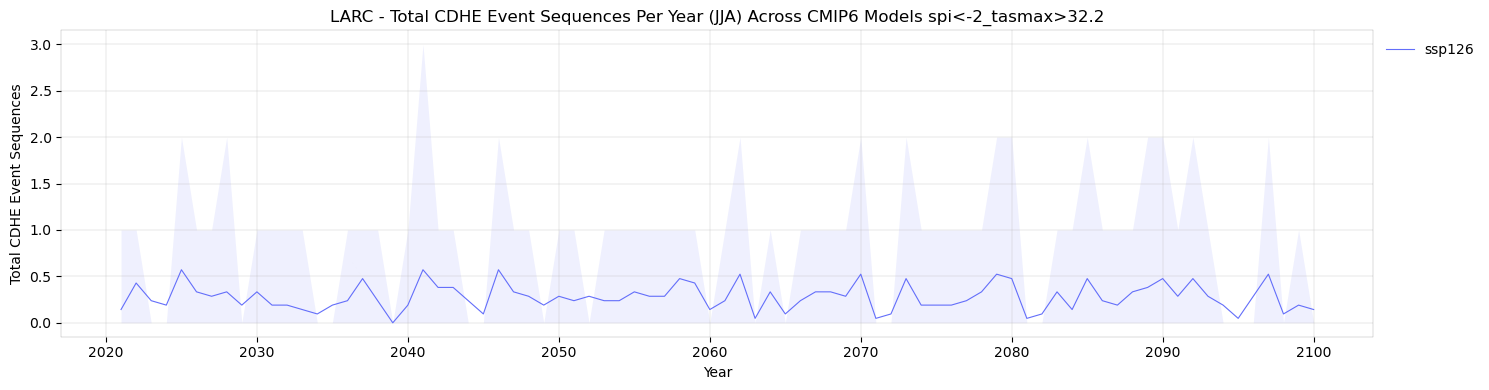

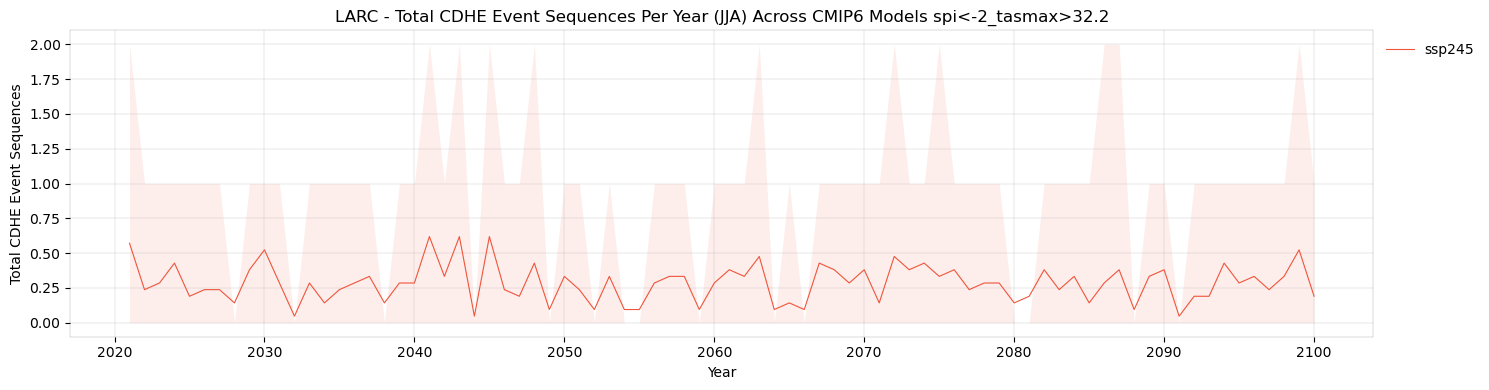

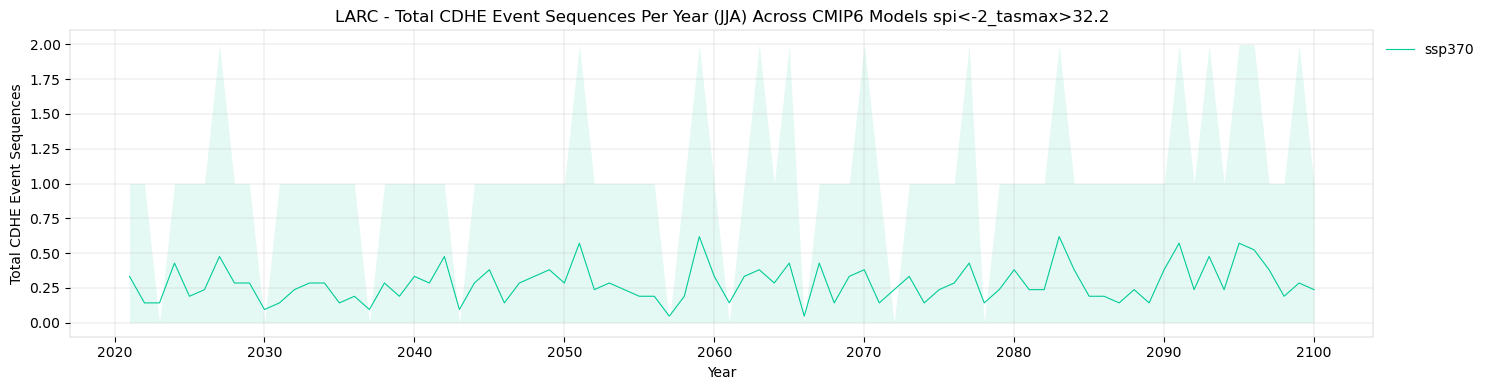

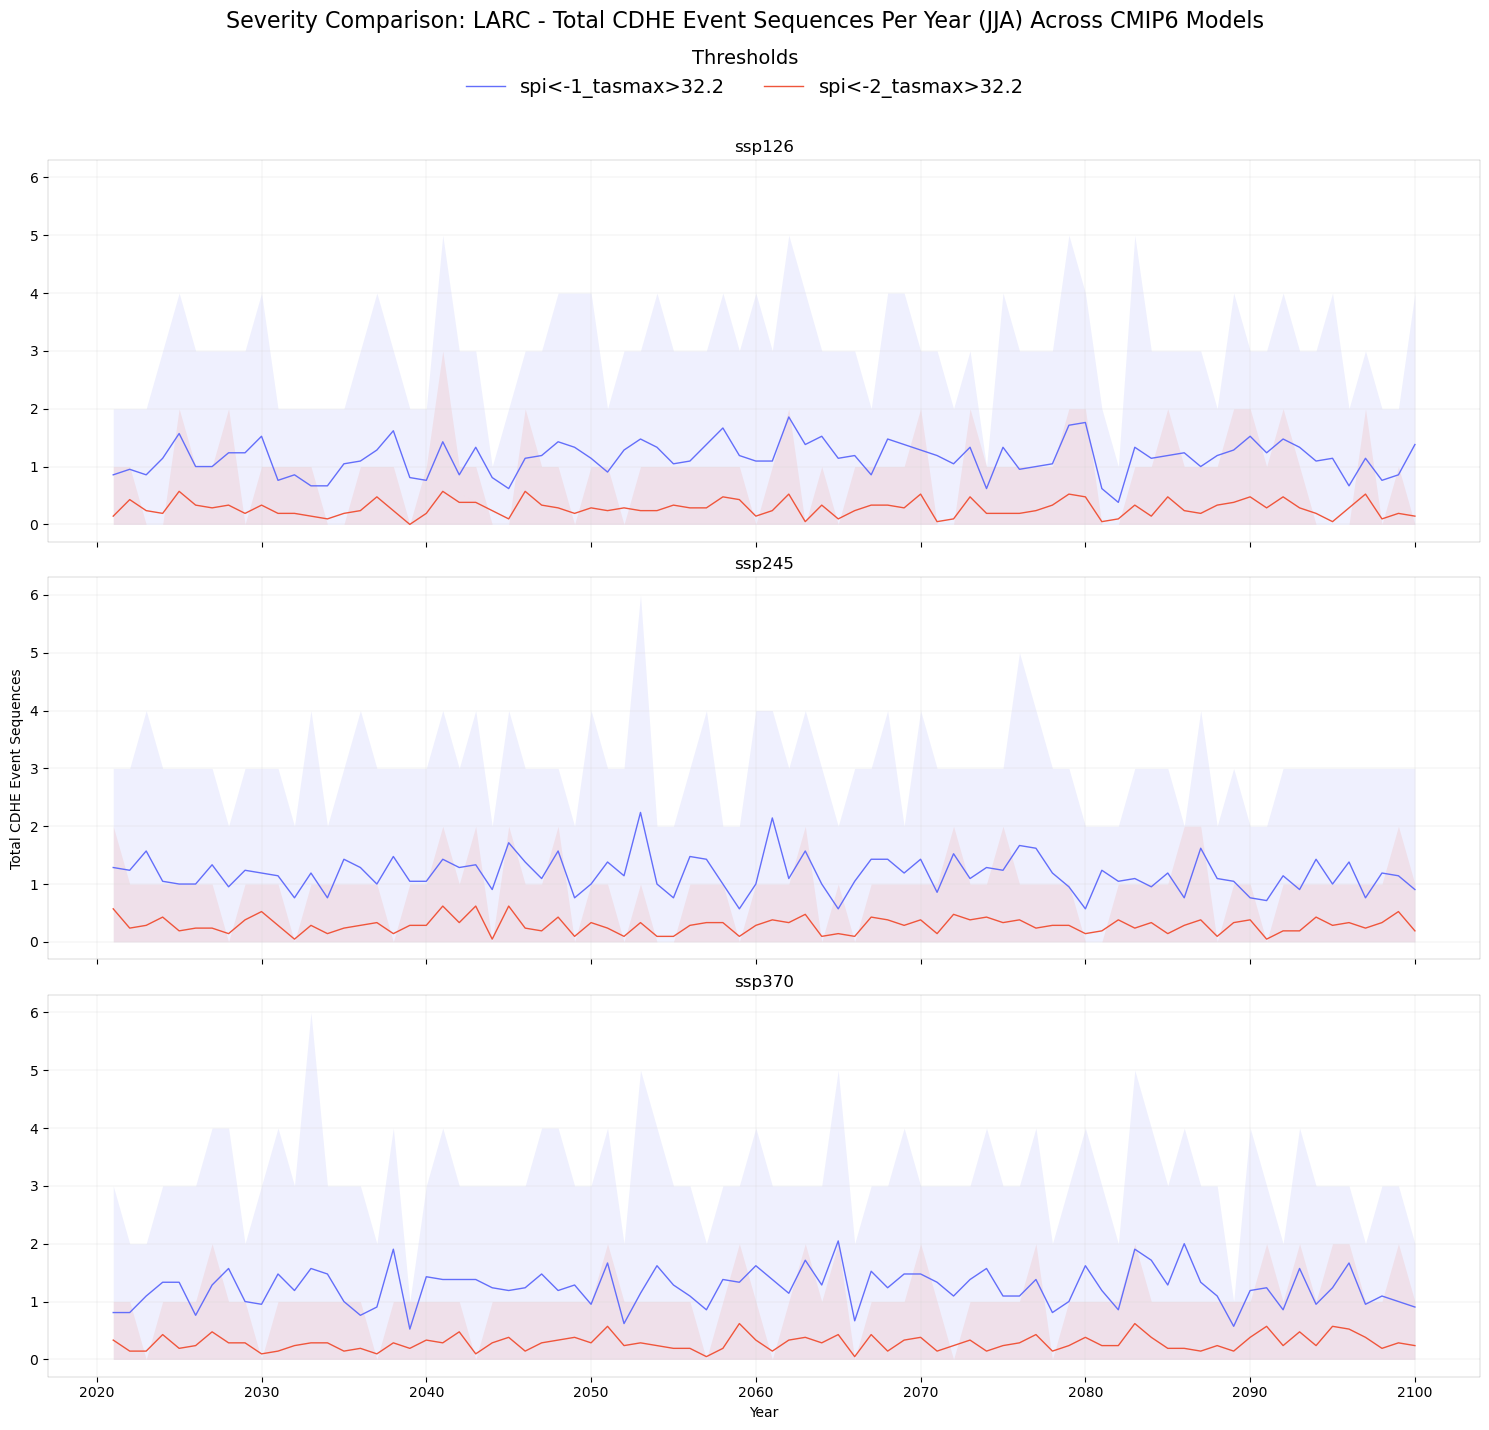

In [8]:
# Total Compound Event Sequences
m = '_sequence_total$'
Plot(center, months, metrics[m], m).all(result, plotly)

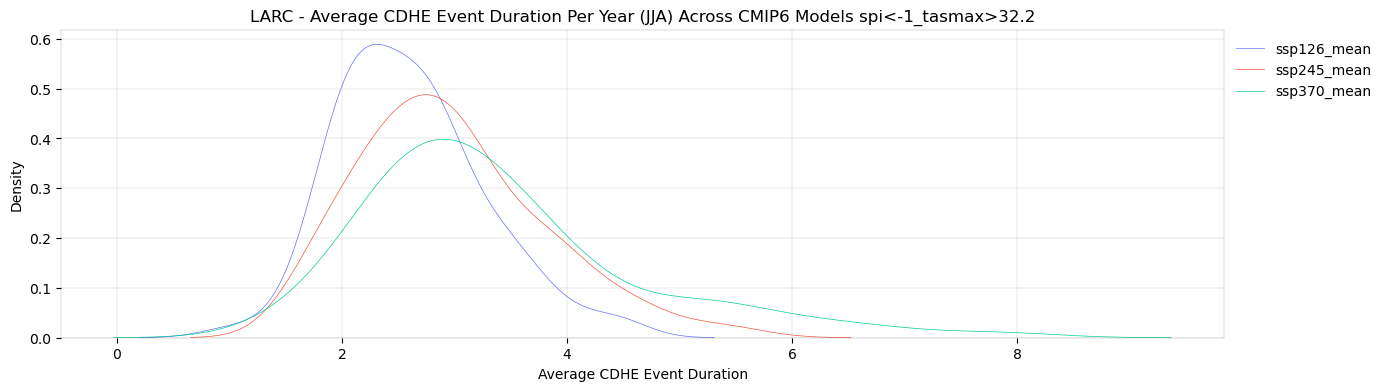

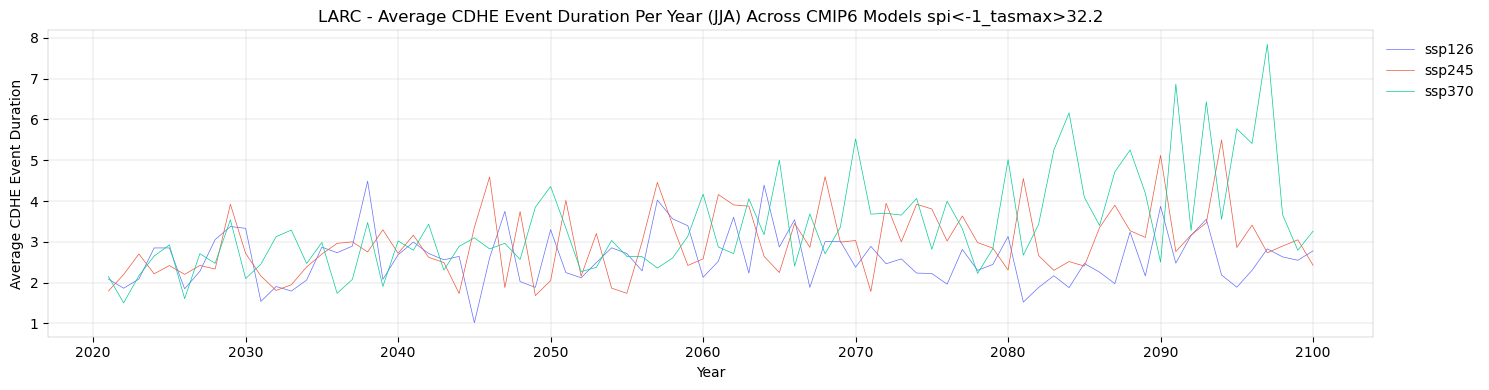

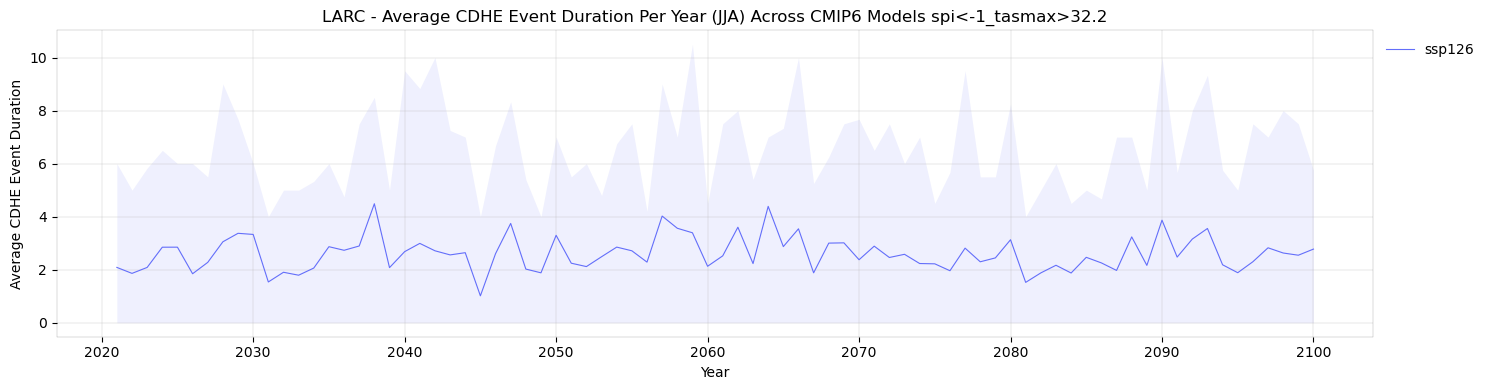

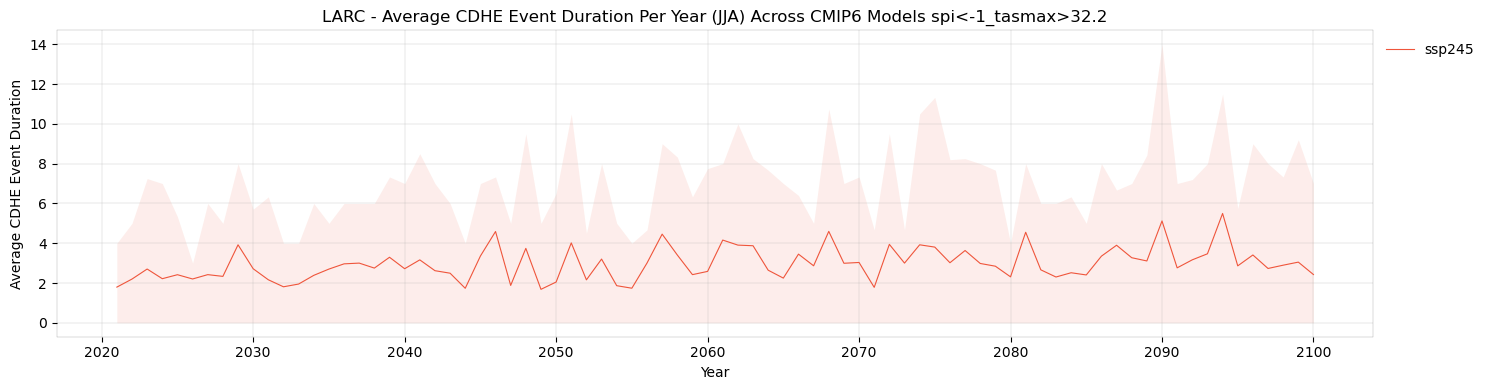

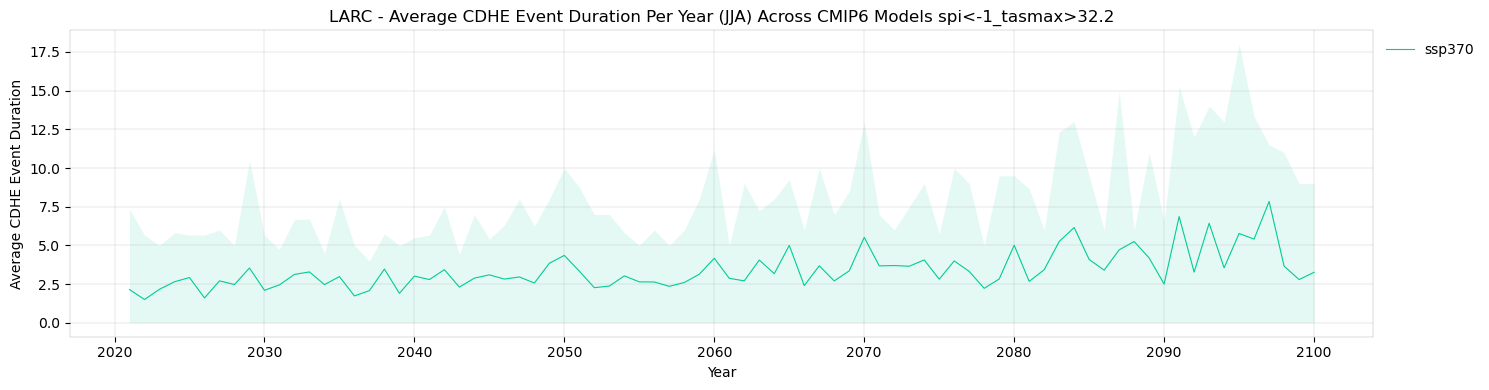

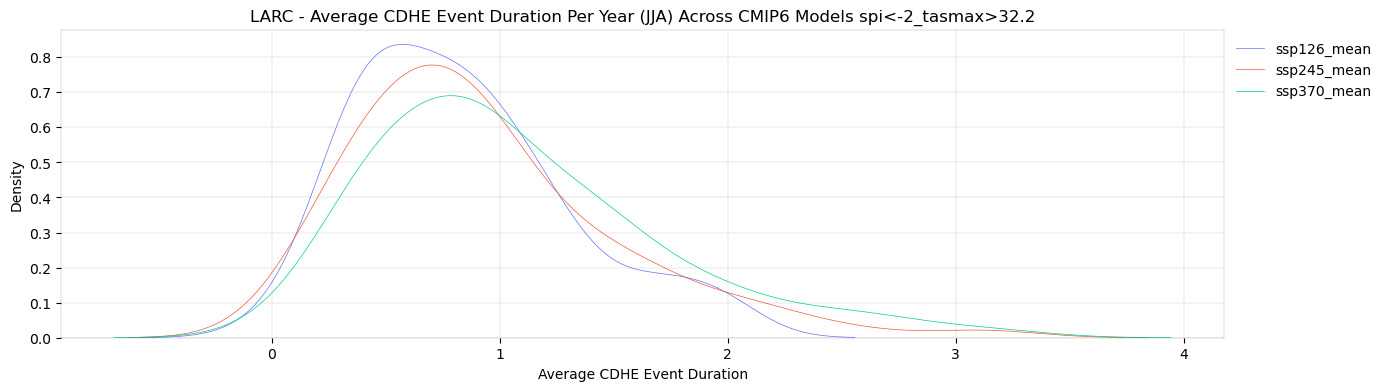

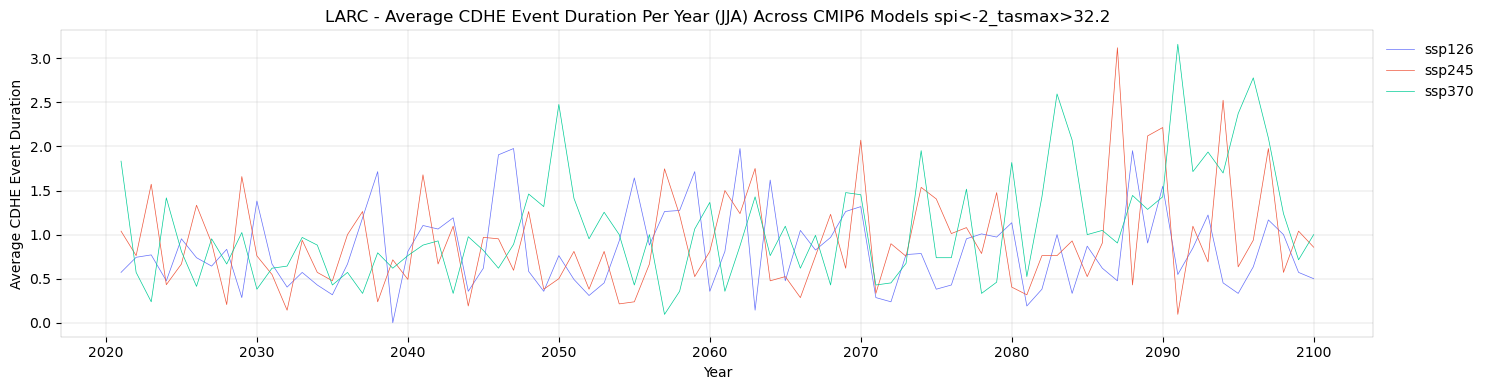

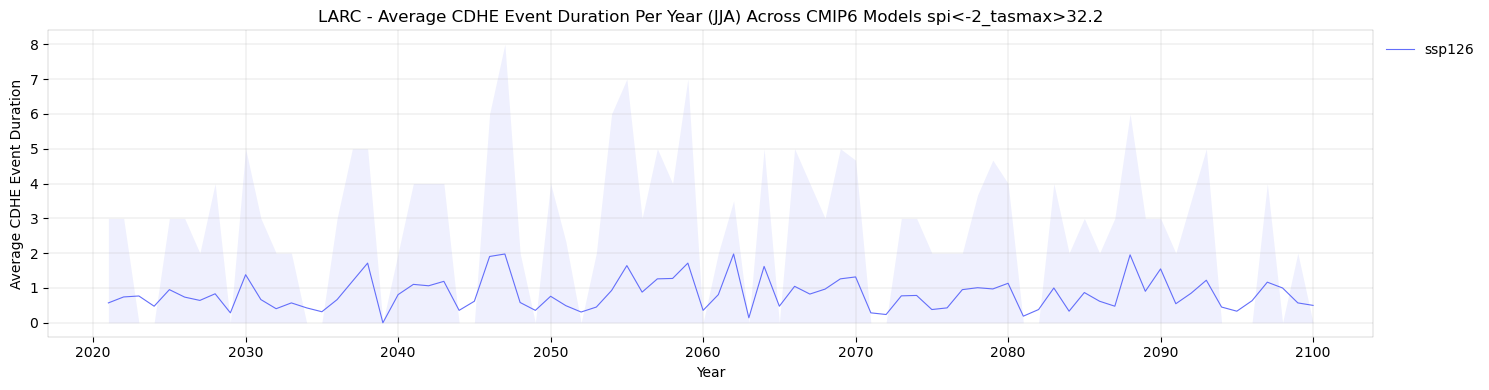

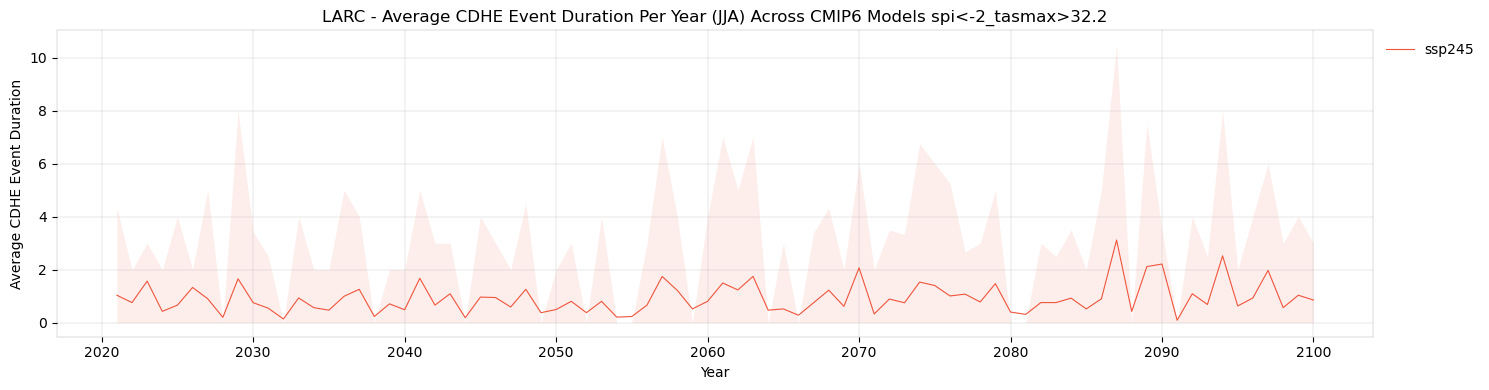

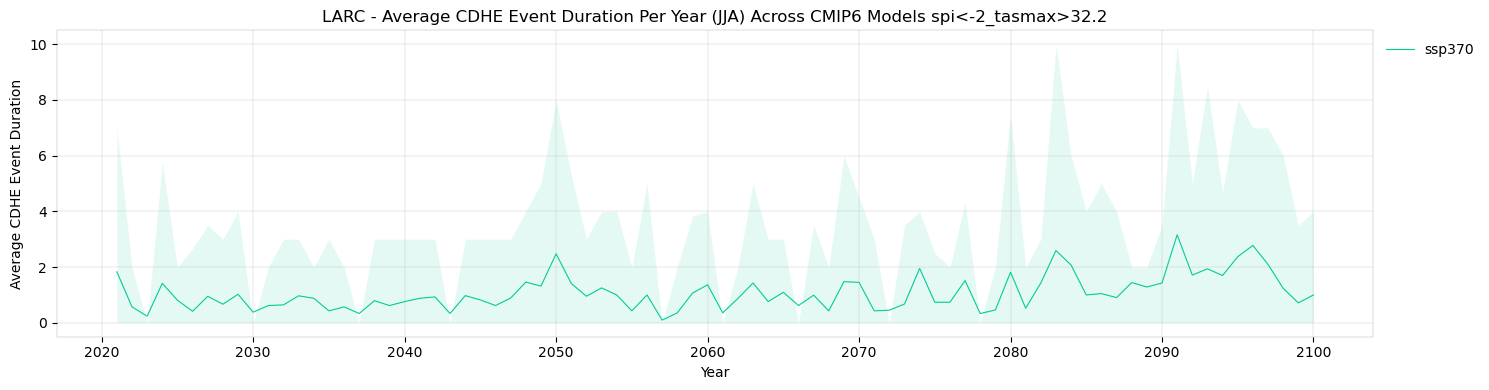

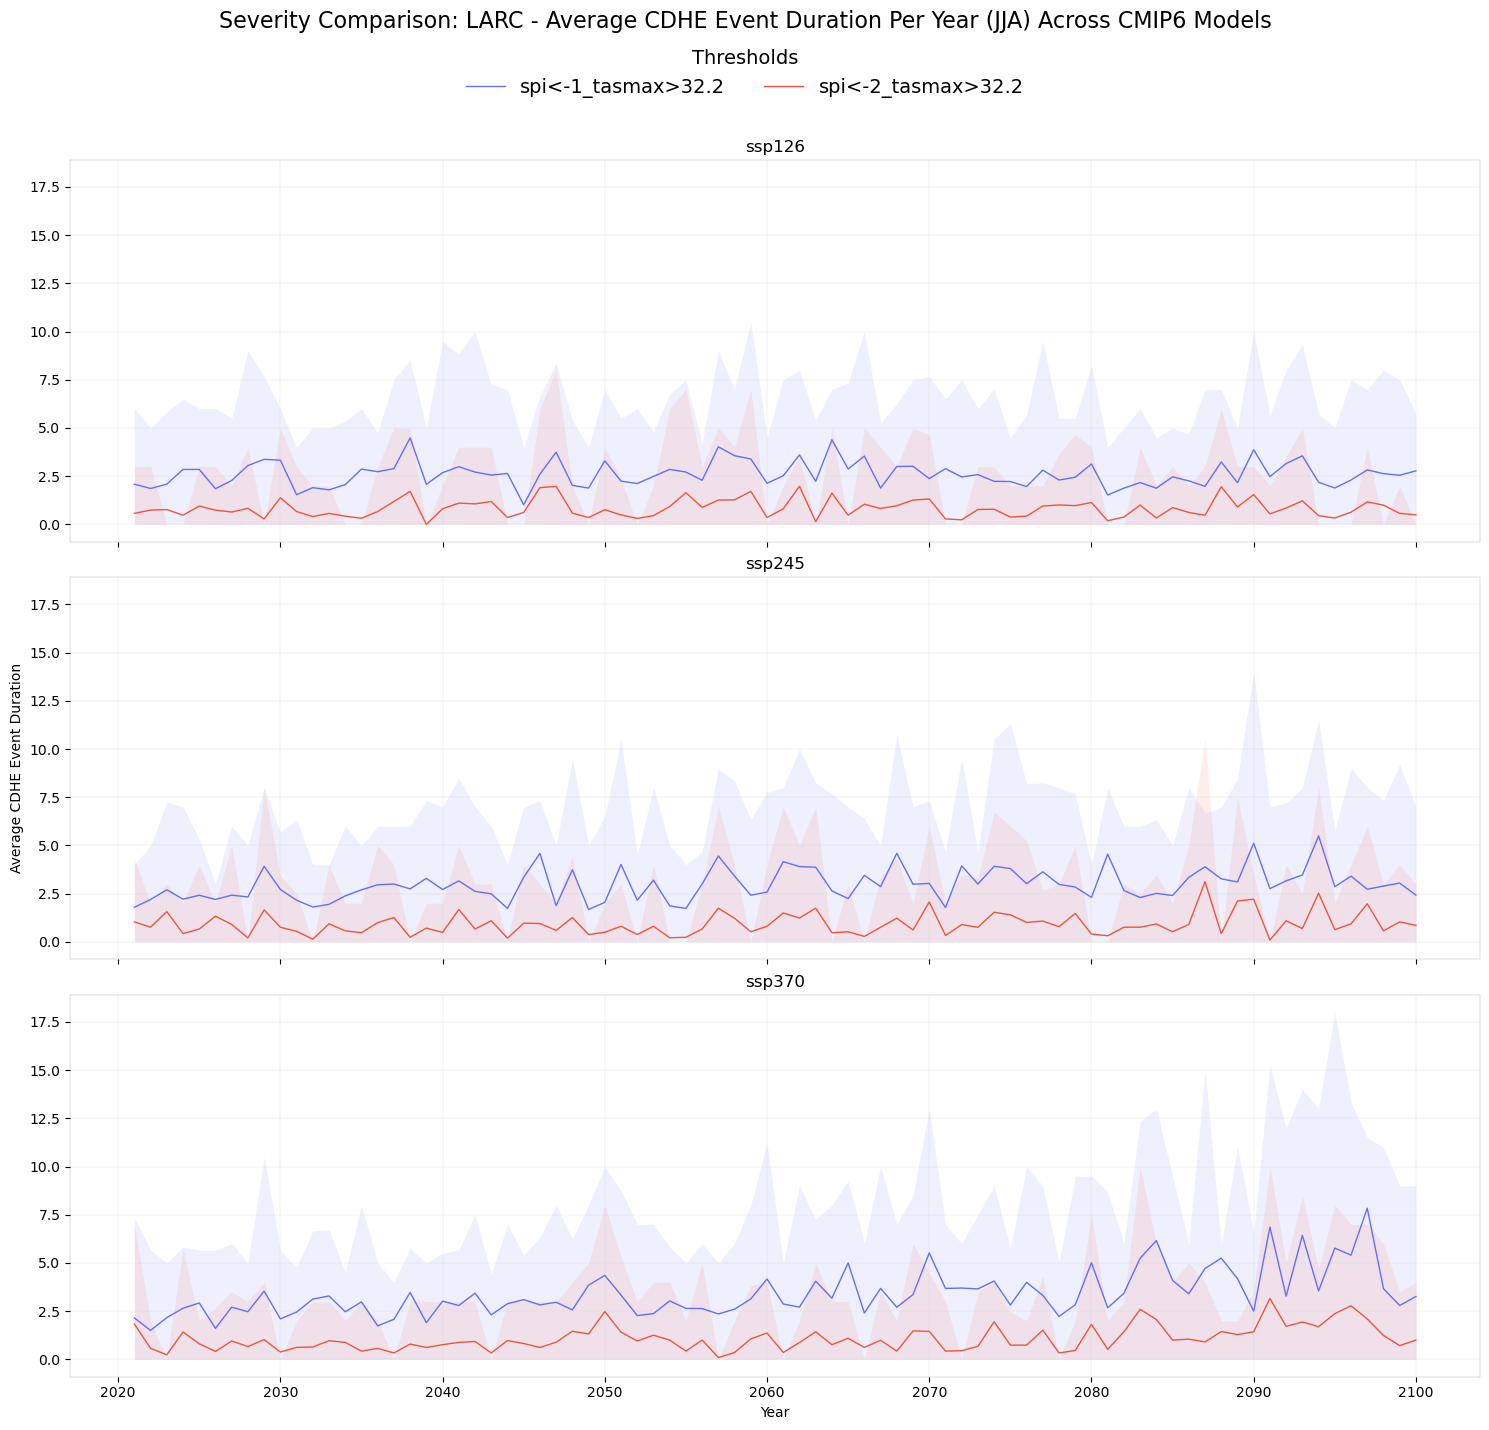

In [9]:
# Average Compound Event Duration
m = '_duration_mean$'
Plot(center, months, metrics[m], m).all(result, plotly)

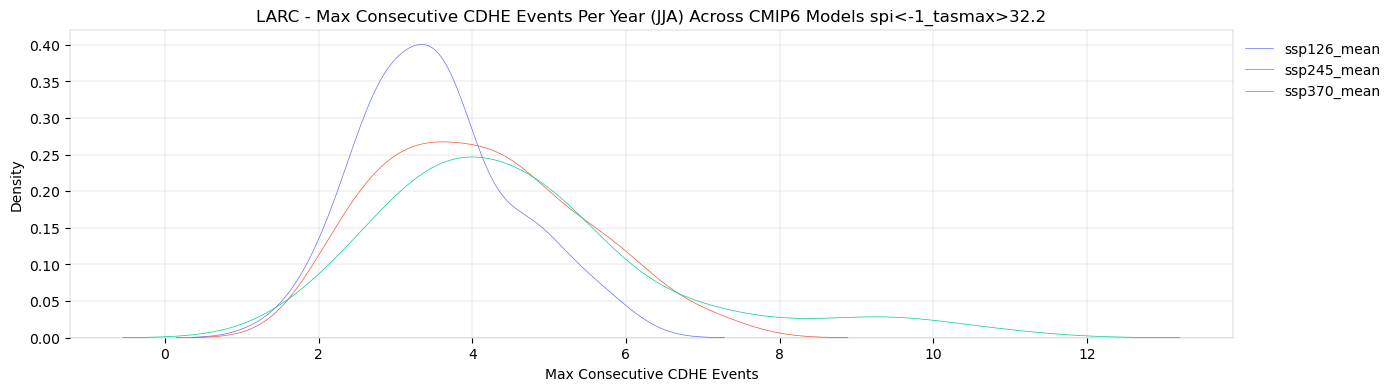

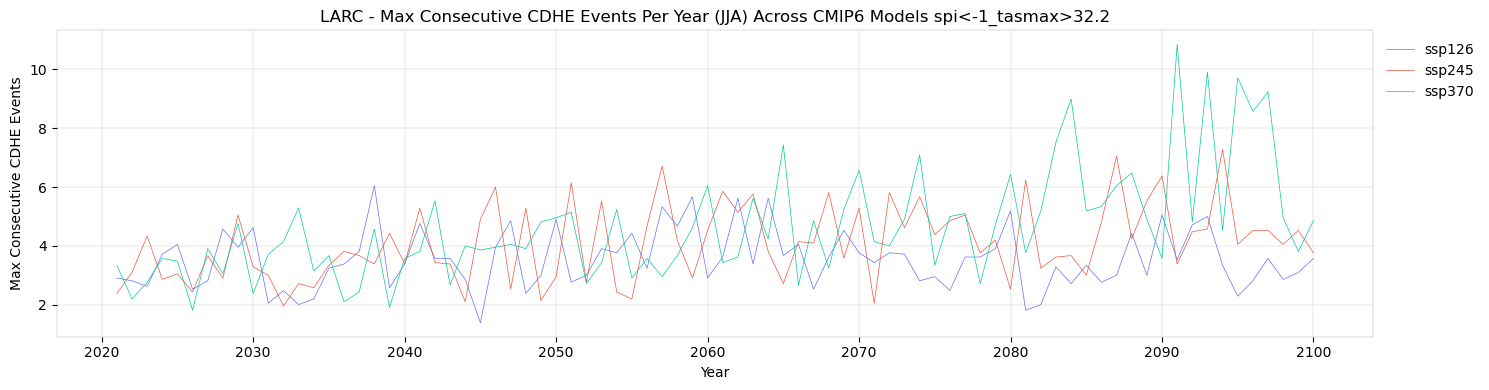

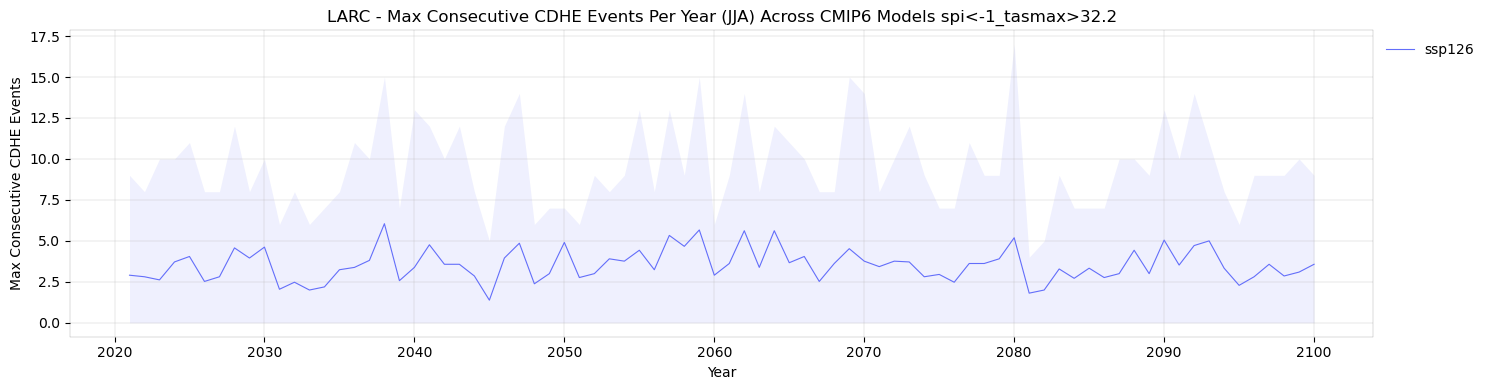

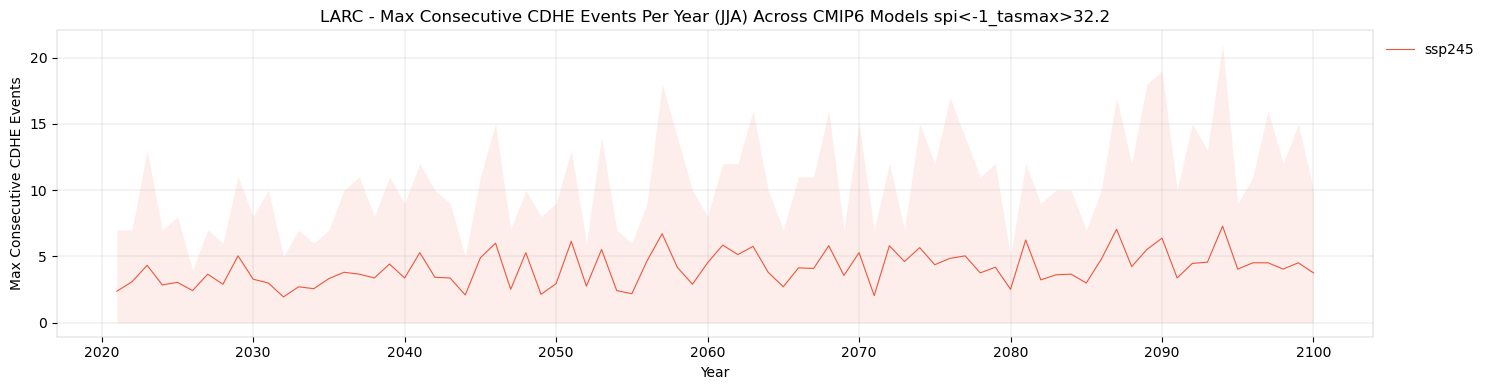

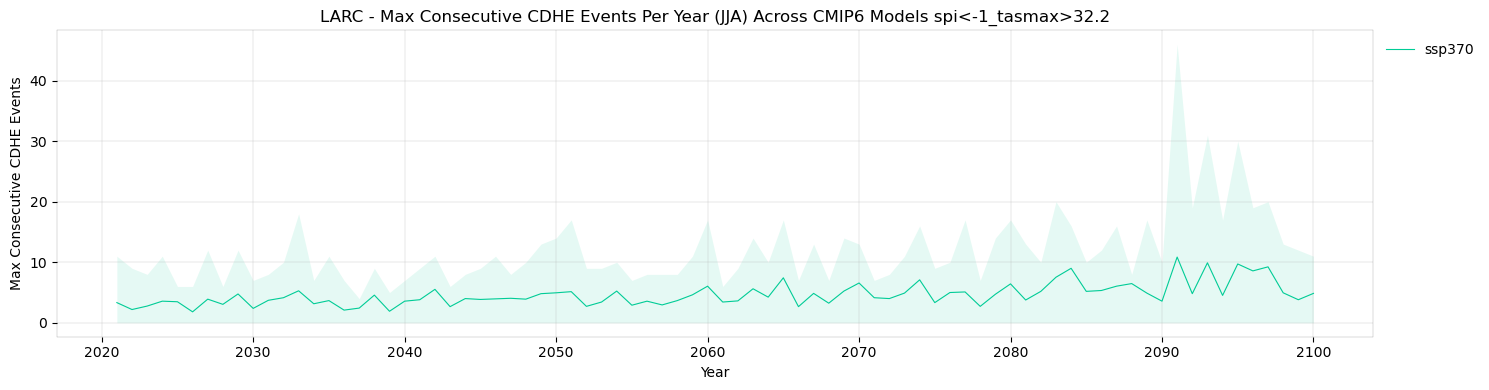

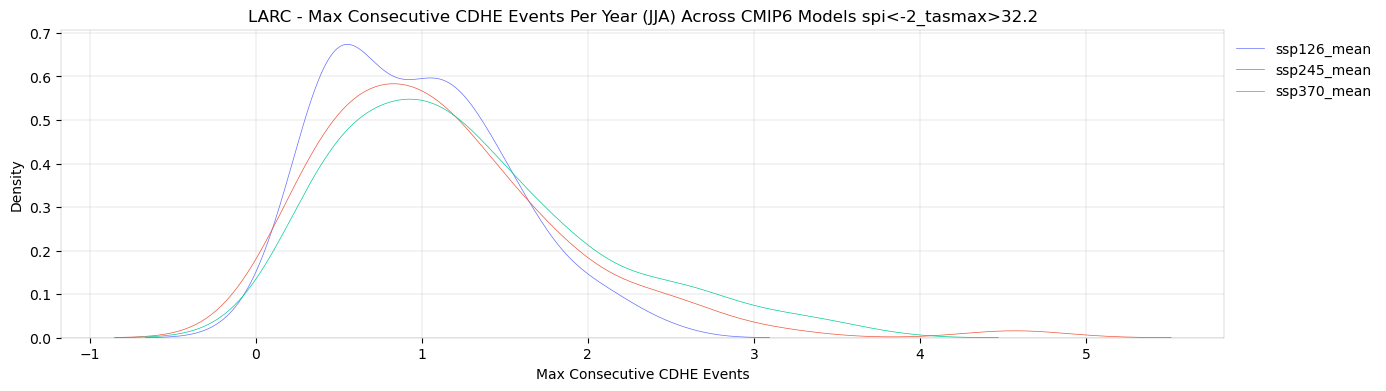

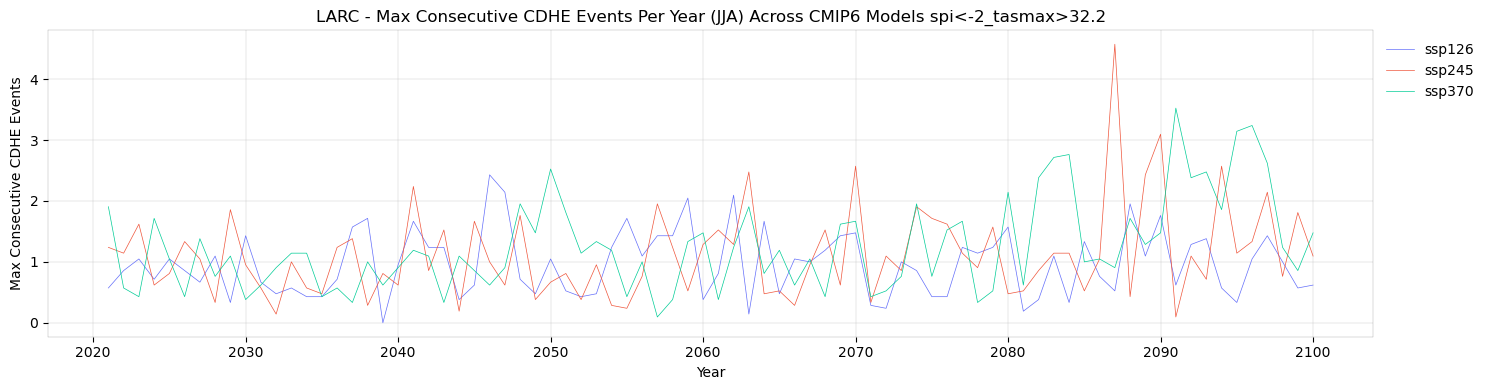

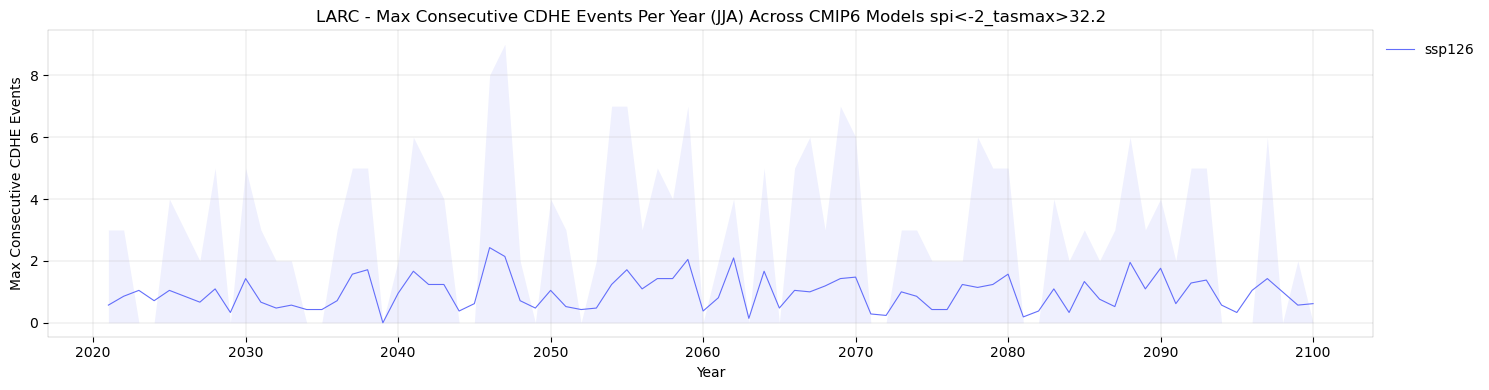

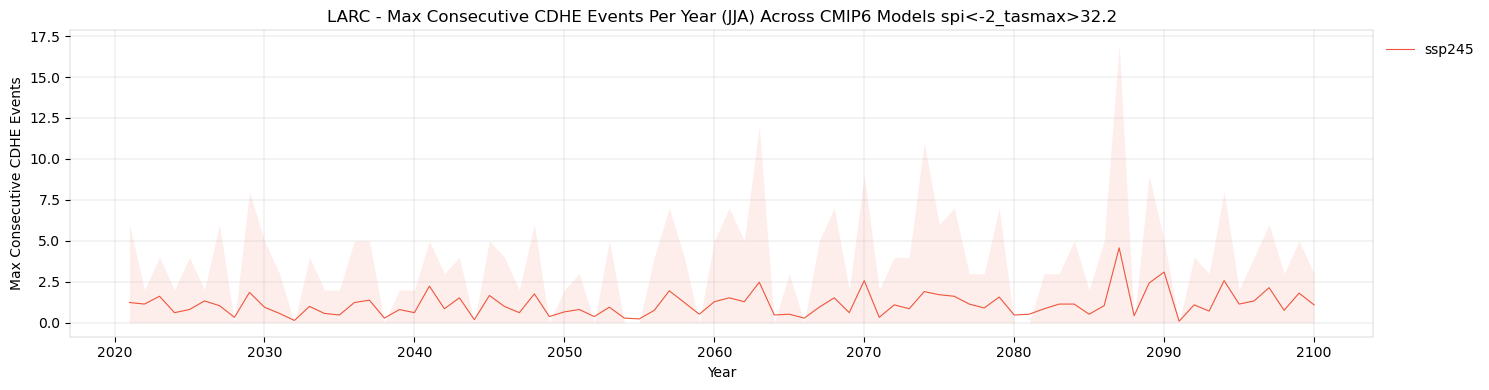

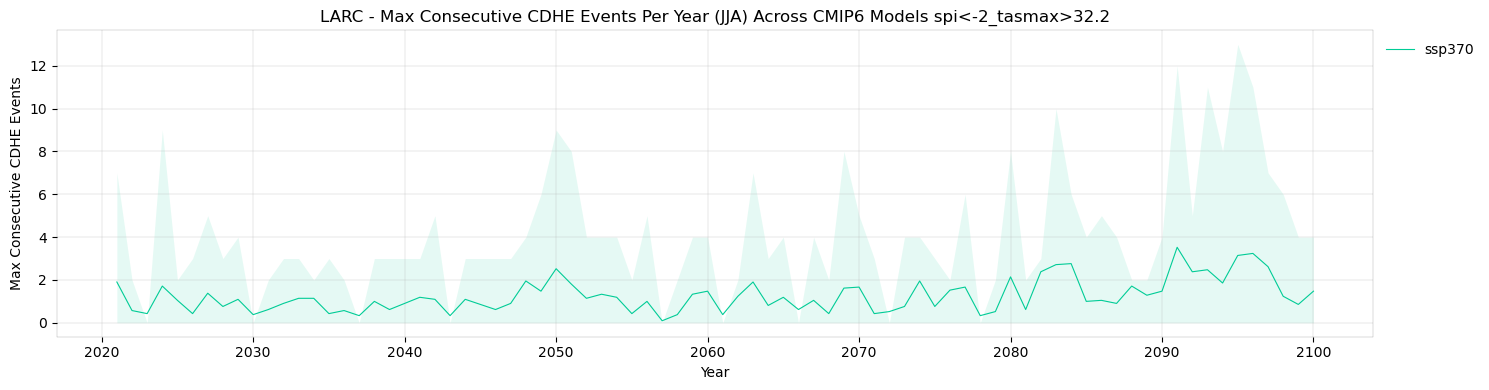

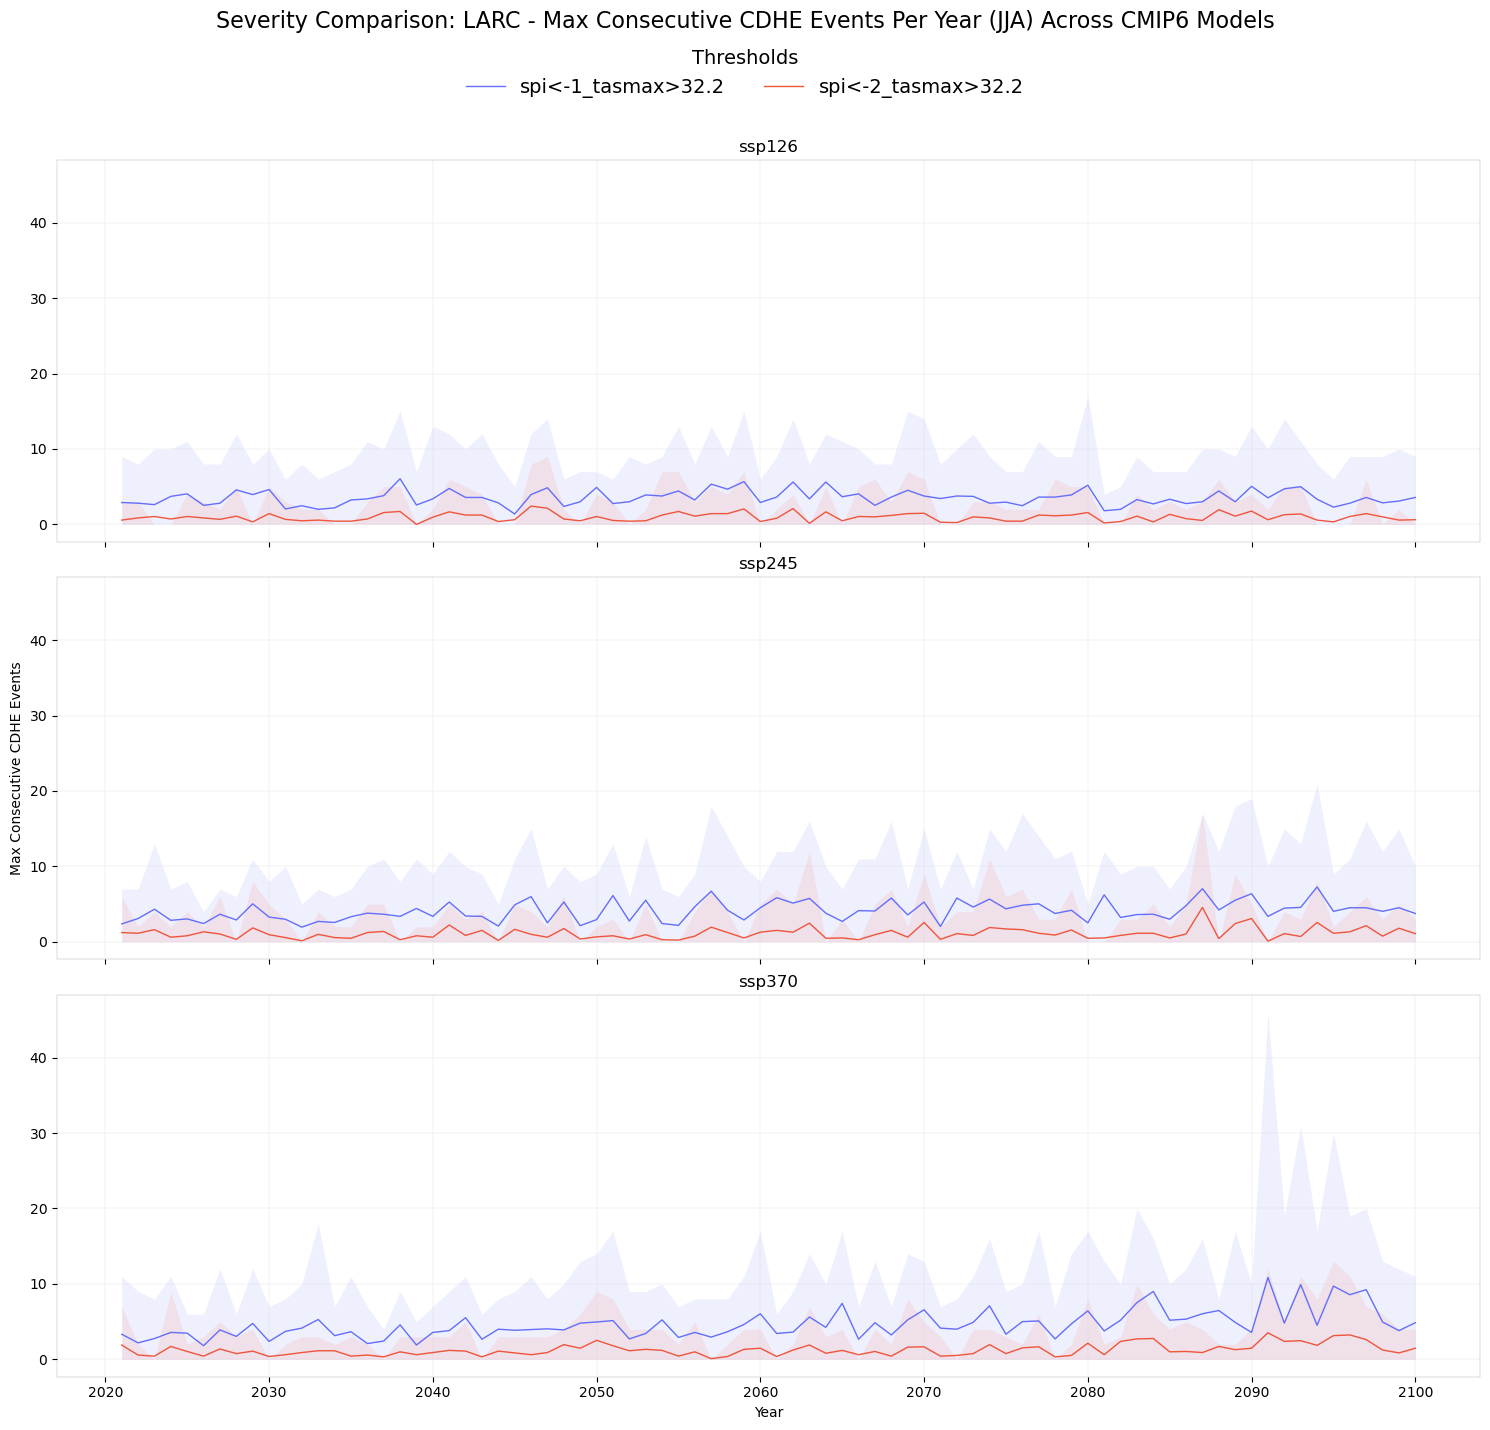

In [10]:
# Max Consecutive Compound Events
m = '_event_max$'
Plot(center, months, metrics[m], m).all(result, plotly)

## Compound Event Comparison: Total Sequences vs Average Duration vs Max Duration

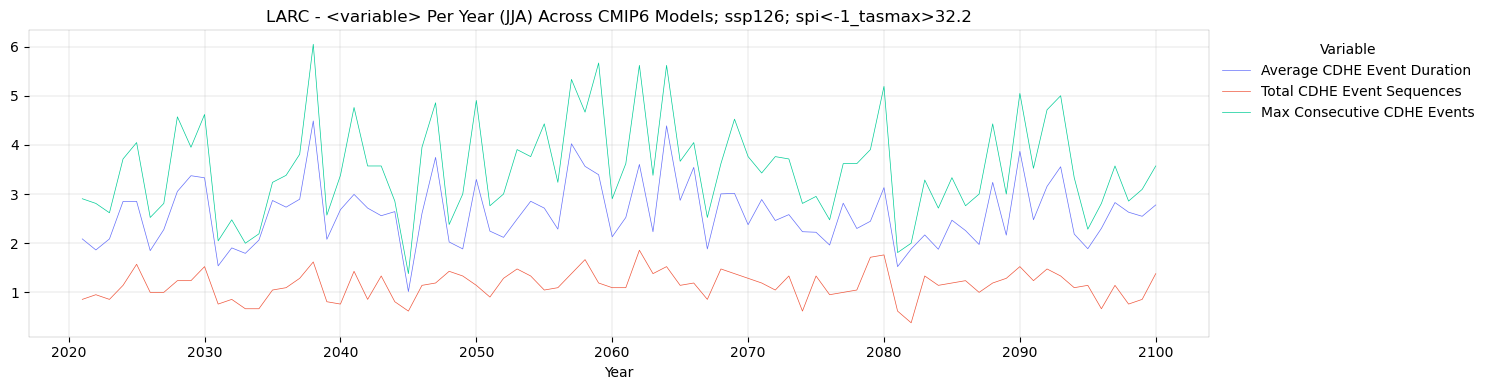

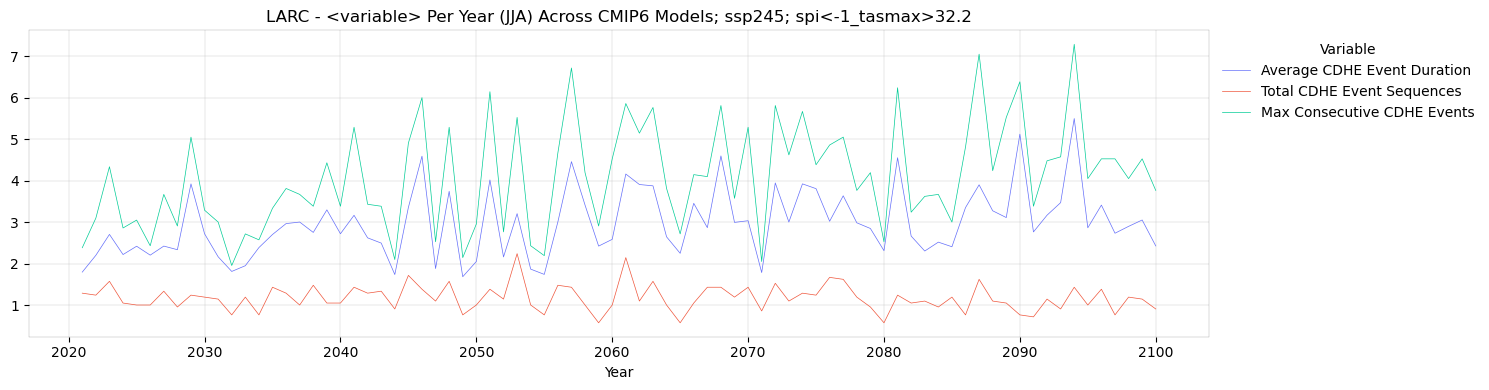

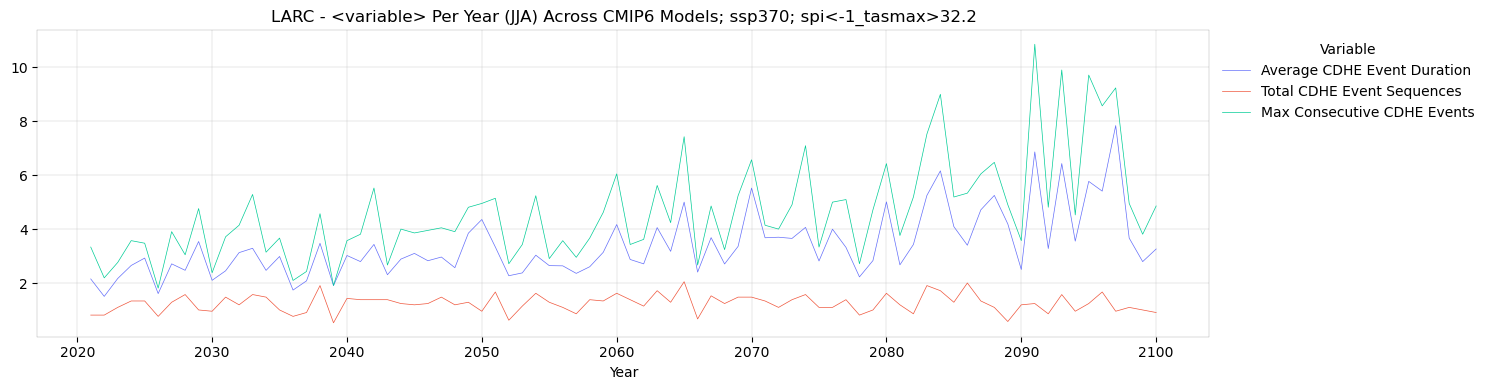

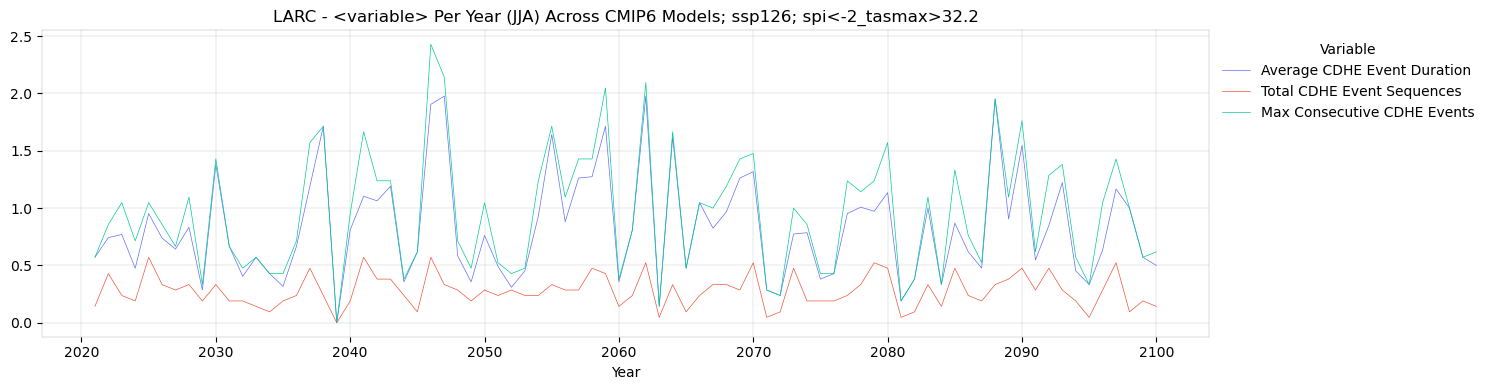

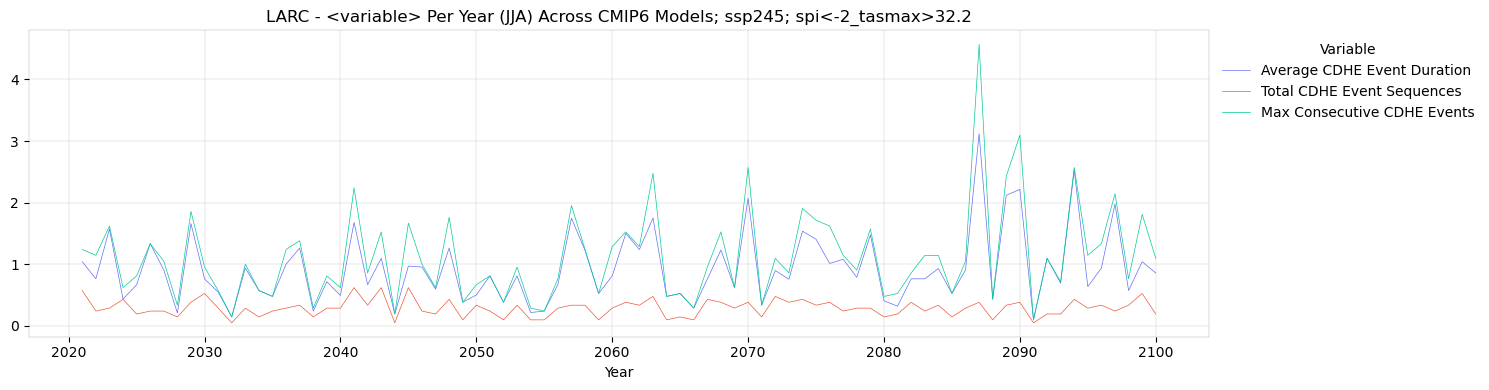

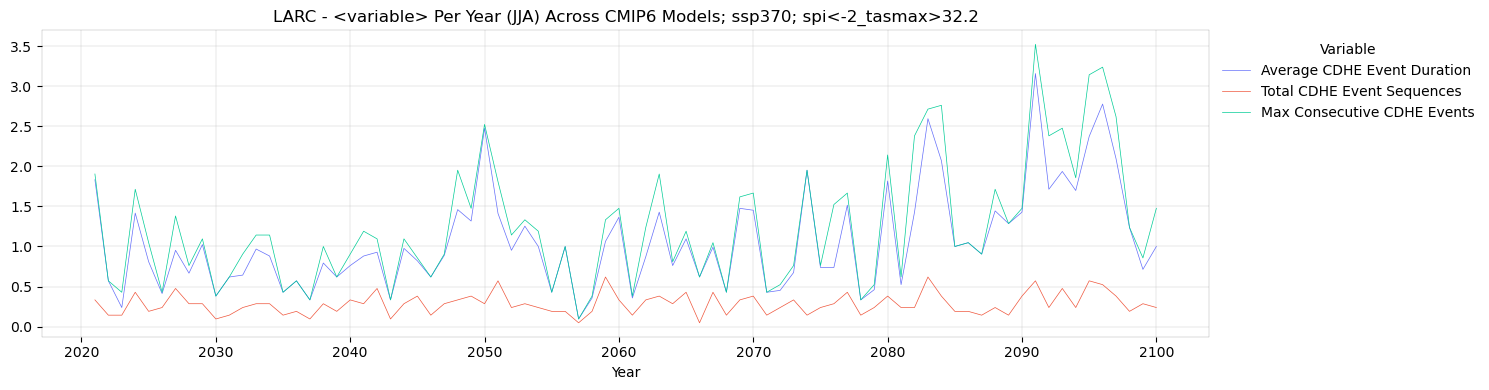

In [11]:
var = ['_duration_mean$', '_sequence_total$', '_event_max$']            
Plot(center, months, '', '').variable_comp(result, var, metrics)

## Time Scale Comparison

In [12]:
%%time
%%capture

scales = [7, 14, 30, 60, 90]#[:2] # days

def process_scale(s, threshold):
    result_, compound_, *_, spi_ = Compound(center, event, months, freq, s, threshold, gamma_n).main()
    thres = result_.threshold.unique()[0]
    result_.insert(0, 'scale', s)
    compound_.insert(0, 'scale', s)
    spi_.insert(0, 'scale', s)
    return (result_.drop(columns='threshold'), compound_.drop(columns='threshold'), 
            spi_.reset_index(), thres)

results, compounds, spis, threshold = zip(*[process_scale(s, thresholds[:1]) for s in scales])

results = pd.concat(results, ignore_index=True)
compounds = pd.concat(compounds, ignore_index=True)
spis = pd.concat(spis, ignore_index=True)
threshold = threshold[0]

CPU times: user 1min 1s, sys: 1.01 s, total: 1min 2s
Wall time: 1min 2s


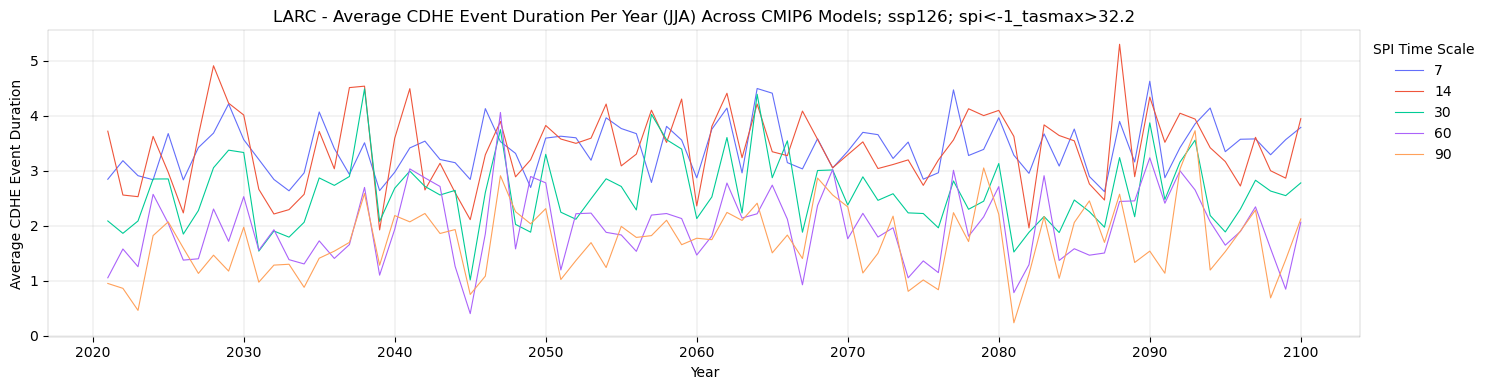

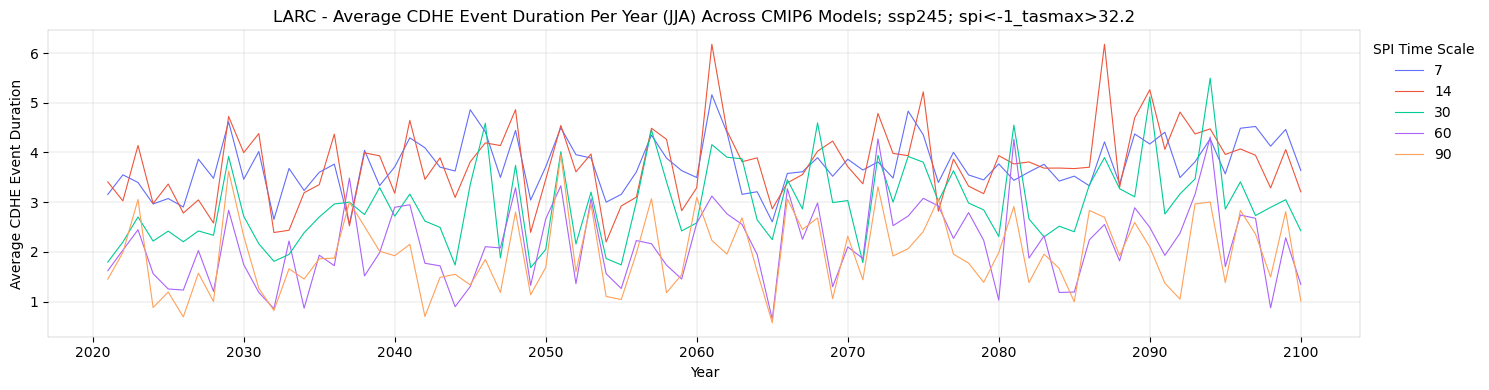

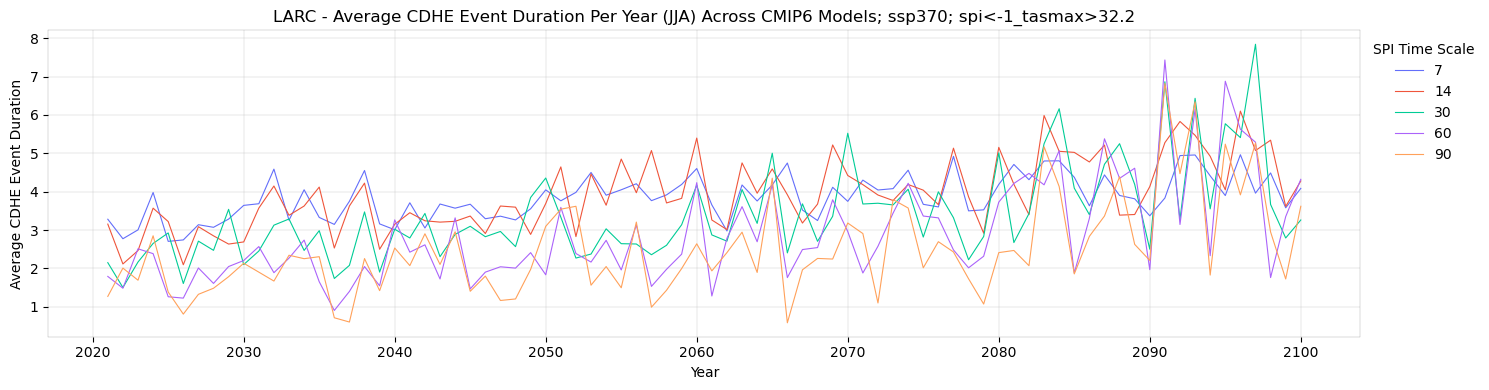

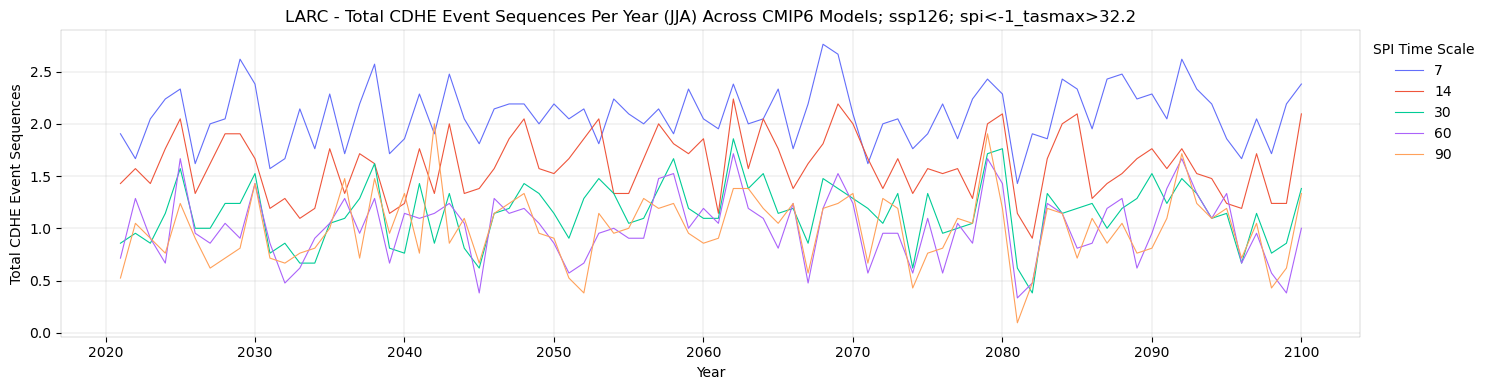

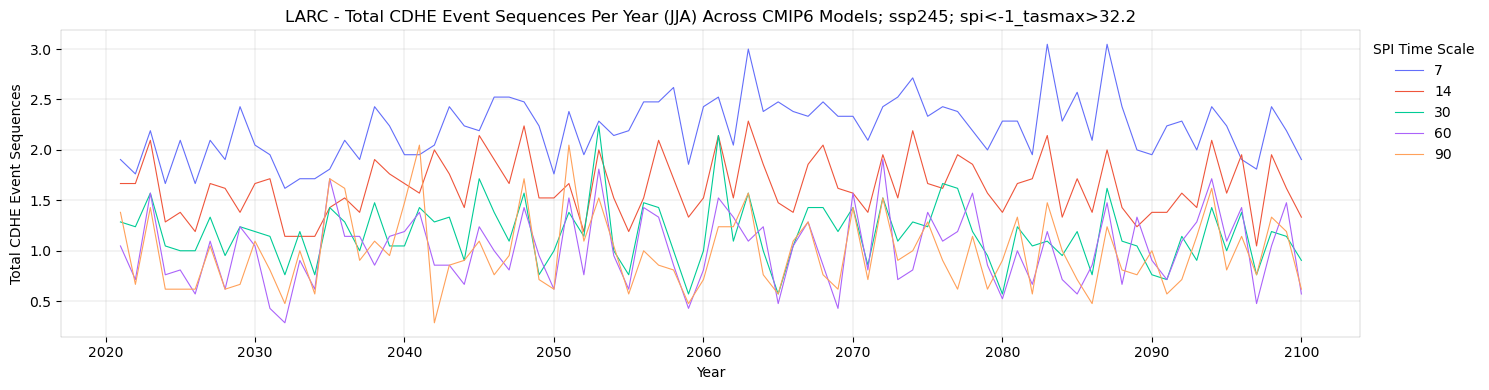

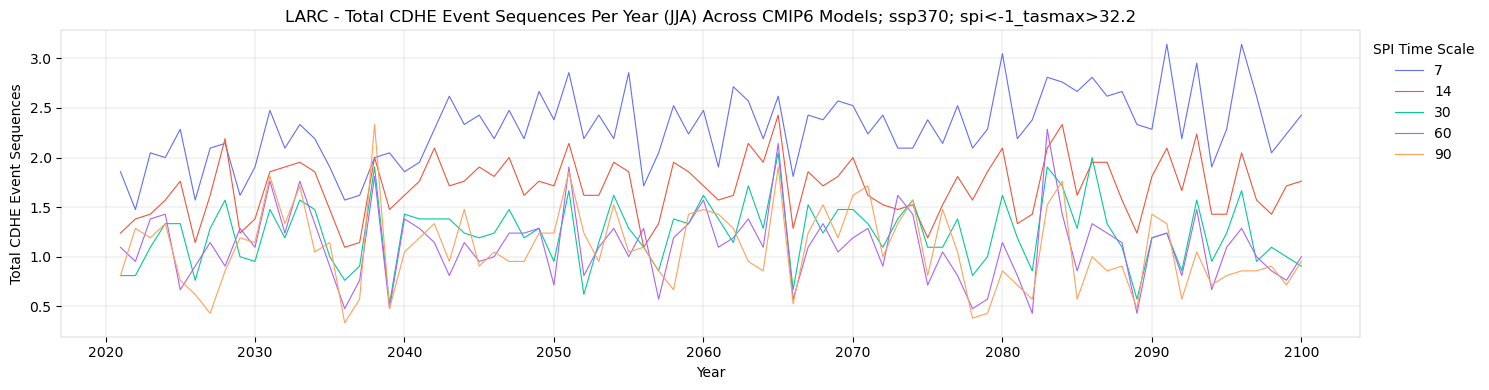

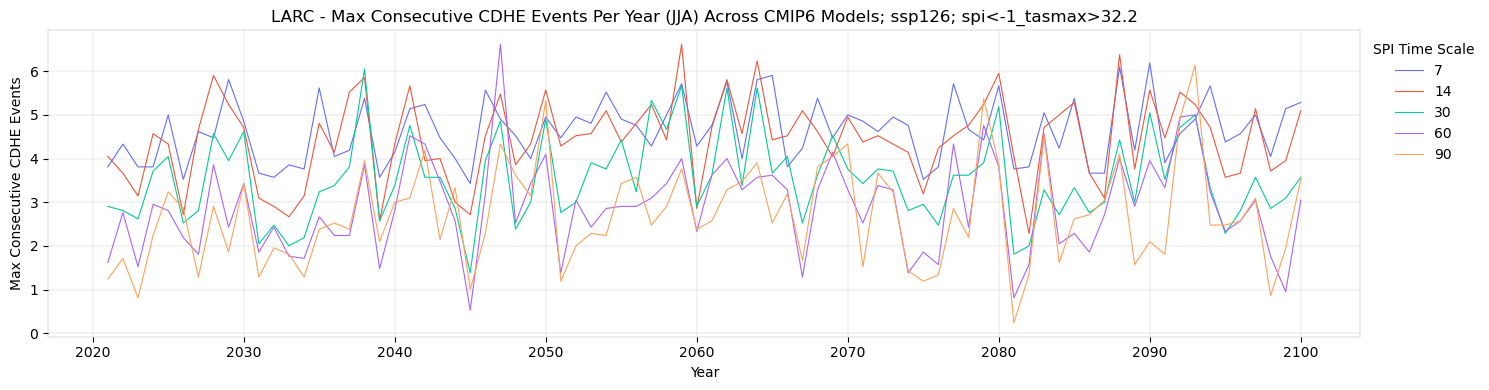

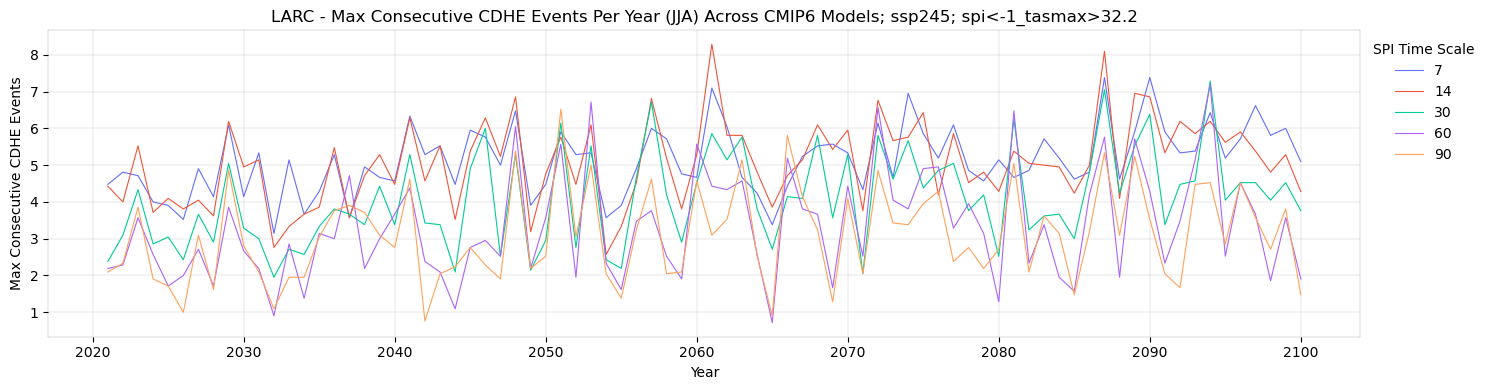

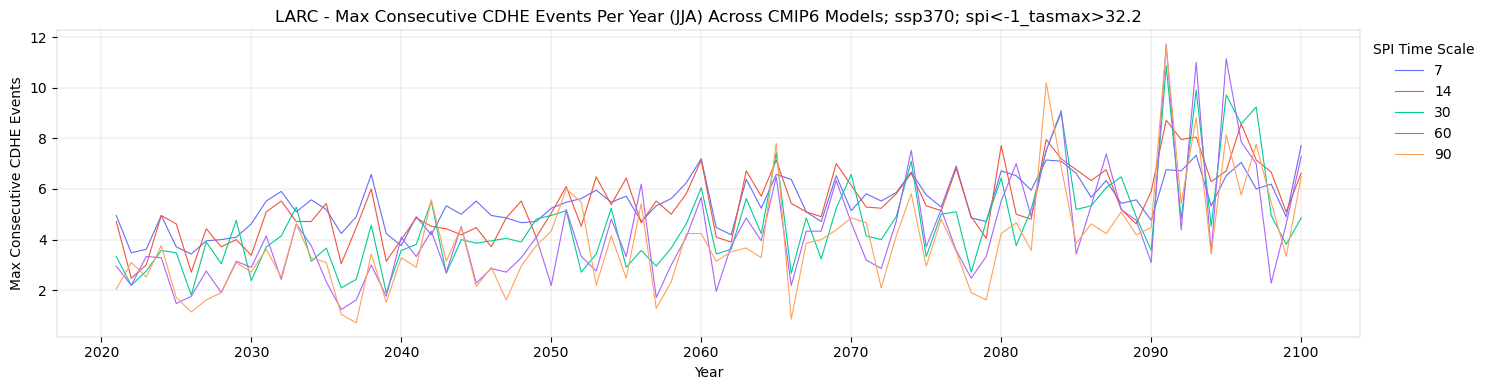

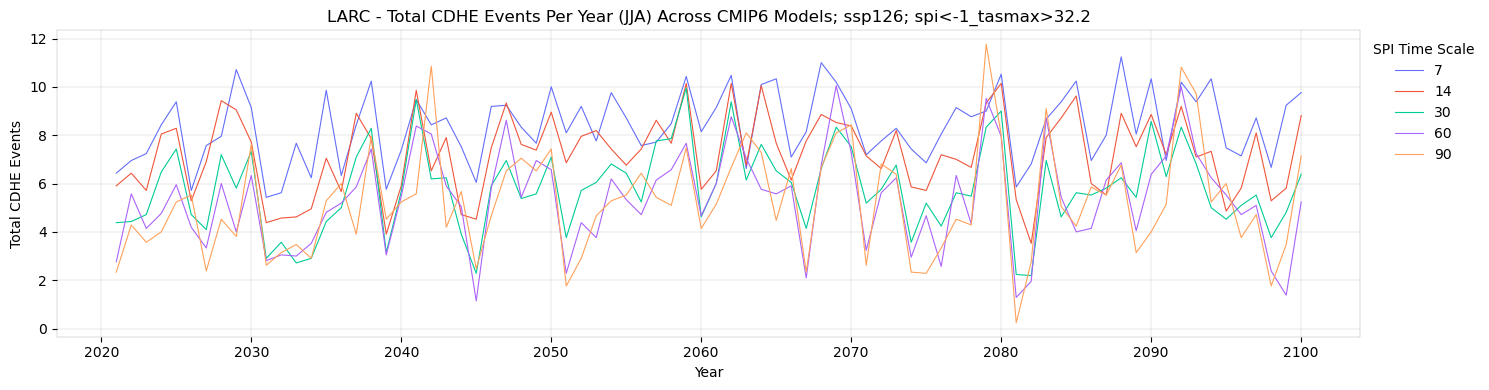

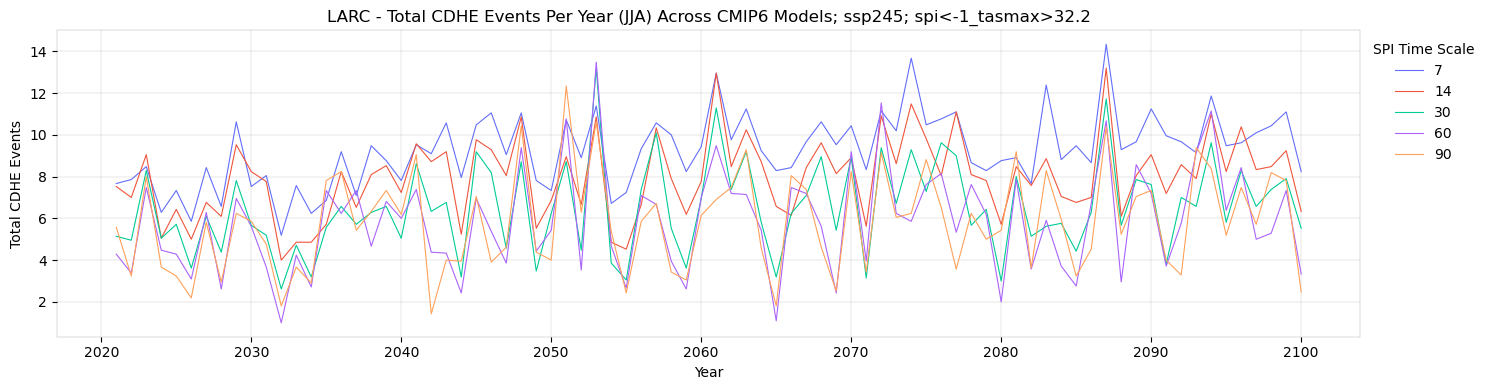

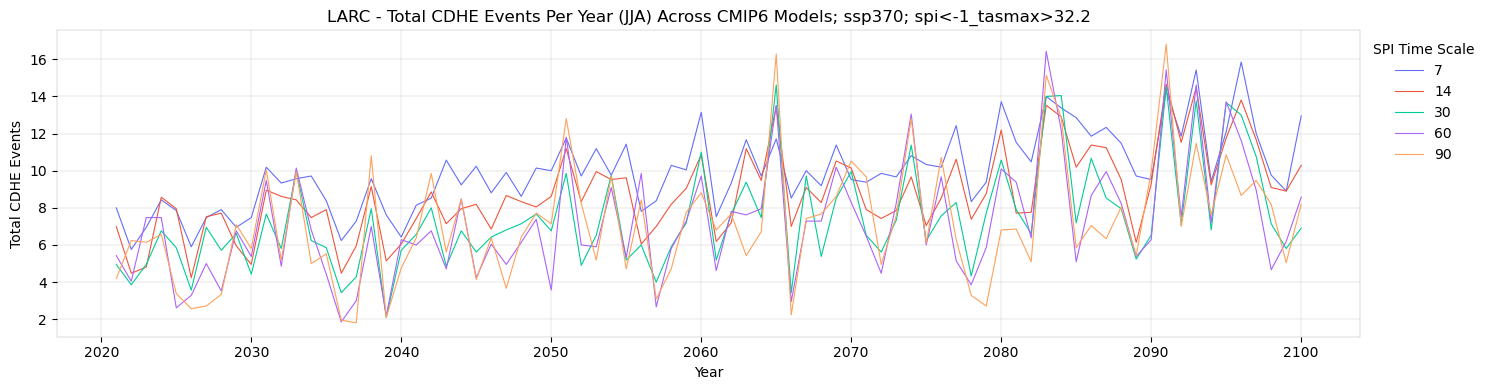

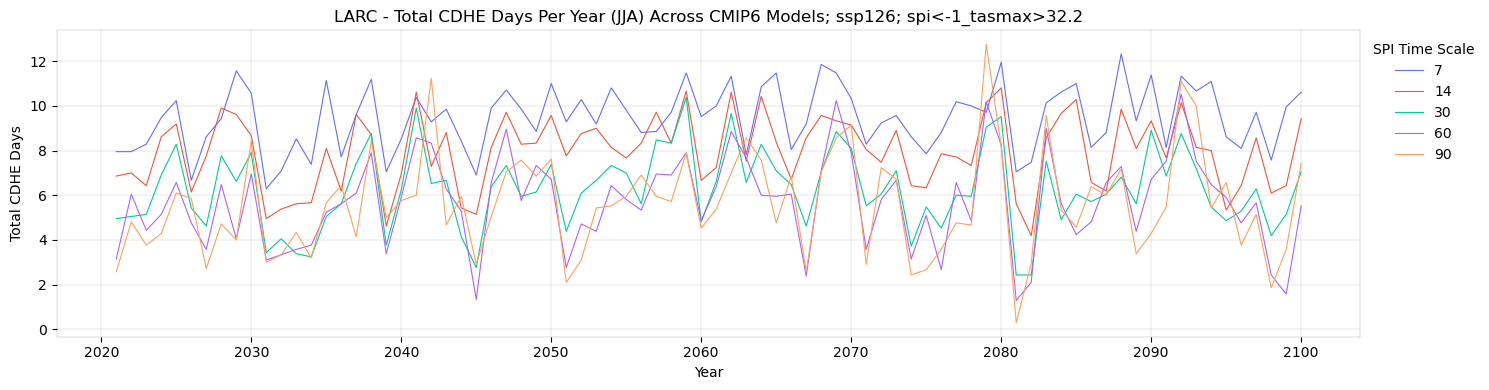

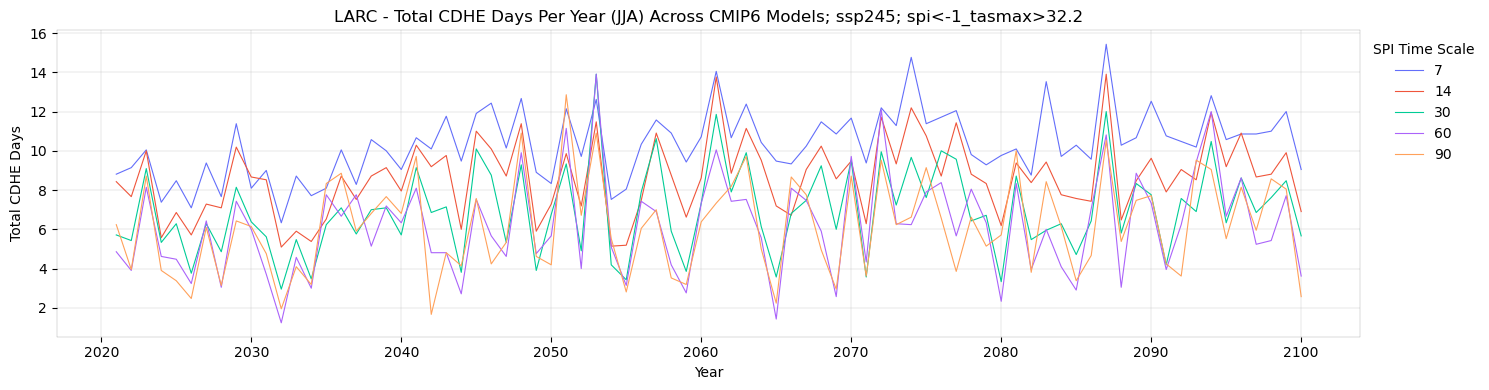

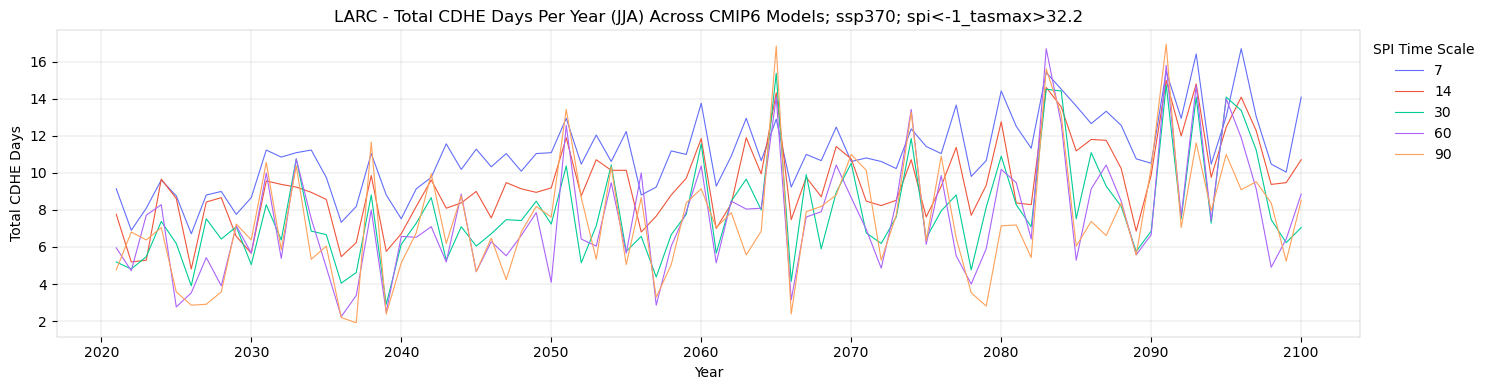

In [13]:
Plot(center, months, '', '').scale_comp(results, metrics, threshold)